#  ML attacks and sensors

### Imports & functions

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from scipy.stats import loguniform
import numpy as np
import seaborn as sns
import pandas as pd

sns.set(font_scale=2.5)

local_options = {
    'plot_confusion': True,
    'multi_class'   : True,
    'features_importance': False
    }

#backup
#models = [
#          ('Logistic Regression', LogisticRegression(solver='liblinear')), 
#          ('Random Forest', RandomForestClassifier(max_features='log2', n_estimators=5000)),
#          ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=17, weights='uniform')),
#          ('SVM', SVC(kernel='linear')), 
#        ]

models = [
          ('Logistic Regression', LogisticRegression(solver='liblinear', C=1000, penalty='l1')), 
          ('Random Forest', RandomForestClassifier(max_features='log2', n_estimators=5000)),
          ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='uniform')),
          ('SVM', SVC(kernel='linear')), 
        ]

In [4]:
param_distr = {"Logistic Regression": {'penalty' : ['l1', 'l2'],
                                        'C' : loguniform(1e-5, 100),
                                        'solver' : ['newton-cg', 'lbfgs', 'liblinear']},
               "Random Forest": {'n_estimators' : list(range(10,101,10)),
                                  'max_features' : list(range(6,32,5))}, # add iterations
               "SVM": {'C': np.linspace(0.1,101,100)}
              }

def params_research(X_train, y_train):
    for name, model in models:
        print(name)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
        search = RandomizedSearchCV(model, param_distr[name], n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X, y)
        #kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=92722)
        #clf = RandomizedSearchCV(model, param_distr, cv=kfold, random_state=1238, scoring='accuracy')
        #search = clf.fit(X_train, y_train)
        print(result.best_score_)
        print(result.best_params_)

In [5]:
# Logistic regression: C=3, solver=liblinear
# Random Forest: n_estimators=70, max_features=6
#params_research(X, y)

In [62]:
def run_exps(X_train, y_train, X_test, y_test, img_name):
    dfs = []
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,30))
    fig.suptitle(img_name)
    plt.rcParams.update({'font.size': 22})
    results = []
    names = []
    feature_result = {}
    
    if local_options['multi_class']:
        target_names = ['Bulb', 'Camera', 'Fire', 'Plug', 'SmartTv', 'Thermo',  'Connect', 'Quick', 'Heavy']
        scoring = ['f1_macro','precision_macro', 'recall_macro']
    else:
        target_names = ['NotAttack', 'Attack']
        scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
        
    for (name, model), ax in zip(models, axes.flat):
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=92722)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print("Model ", name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
    
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
        if local_options['features_importance']:
            if name == "Logistic Regression":
                importance = model.coef_[0]
                feature_result[name] = importance

            if name == "Random Forest":
                importance = model.feature_importances_
                feature_result[name] = importance

            #if name == "KNN":
                #results = permutation_importance(model, X_train, y_train, scoring='accuracy')
                #importance = results.importances_mean
                #feature_result[name] = importance

            if name == "SVM":
                importance = model.coef_
                feature_result[name] = importance

            
        
        if local_options['plot_confusion']:
            pcm = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Purples, display_labels = target_names, ax=ax, normalize='true')
            pcm.ax_.set_title(name)
            ax.grid(False)
    
    plt.savefig("images/{}.png".format(img_name))
    plt.show()
    final = pd.concat(dfs, ignore_index=True)
    return final, feature_result

### Los geht's

In [36]:
# read dataframe from...
df = pd.read_csv('ml_dataset.csv')
df

,TotPkts,SrcPkts,DstPkts,TotBytes,SrcBytes,DstBytes,Dur,Load,SrcLoad,DstLoad,...,Type,Dir_->,Dir_<?,Dir_<?>,Dir_?>,State_ACC,State_CON,State_FIN,State_REQ,State_RST
0,0.003981,0.004292,0.003215,0.000522,0.000455,0.003149,0.831979,0.000113,0.000098,0.000015,...,1,1,0,0,0,0,0,0,0,1
1,0.001810,0.001717,0.003215,0.000293,0.000226,0.002987,0.000409,0.111275,0.082299,0.028974,...,1,1,0,0,0,0,1,0,0,0
2,0.014839,0.002575,0.057878,0.035688,0.000319,0.912001,0.888872,0.007976,0.000059,0.007911,...,1,1,0,0,0,0,1,0,0,0
3,0.001810,0.000858,0.006431,0.000306,0.000119,0.005974,0.819433,0.000058,0.000014,0.000043,...,1,1,0,0,0,1,0,0,0,0
4,0.001810,0.000858,0.006431,0.000287,0.000106,0.005813,0.103401,0.000437,0.000102,0.000334,...,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37405,0.283388,0.185408,0.565916,0.978070,0.986915,0.468898,0.995814,0.200237,0.196555,0.003724,...,1,1,0,0,0,0,1,0,0,0
37406,0.189287,0.201717,0.086817,0.152644,0.154111,0.071933,0.156705,0.198612,0.195081,0.003573,...,1,1,0,0,0,0,0,0,0,1
37407,0.098082,0.069528,0.176849,0.258937,0.260397,0.147015,0.304940,0.172456,0.168703,0.003789,...,1,1,0,0,0,0,0,0,0,1
37408,0.327543,0.211159,0.665595,0.985801,0.991546,0.551972,0.999363,0.201160,0.196831,0.004370,...,1,1,0,0,0,0,1,0,0,0


### Full dataset

In [72]:
if local_options['multi_class']:
    y = df.Sensor
else: 
    y = df.Type

X = df.drop(['Type', 'Sensor'] , axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=8675309, shuffle=True)

In [38]:
X_test

,DstPkts,DstBytes,DstLoad,DstRate,DstWin
23740,0.000000,0.000000,0.000000,0.000000e+00,0.000000
4443,0.009646,0.007993,0.000078,1.478901e-06,0.043545
98,0.003215,0.002987,0.000037,6.185710e-07,0.022254
743,0.009646,0.127235,0.001459,1.735413e-06,0.043545
24141,0.000000,0.000000,0.000000,0.000000e+00,0.000000
...,...,...,...,...,...
482,0.009646,0.069107,0.001254,2.744273e-06,0.043545
31918,0.688103,0.570137,0.004531,8.577673e-05,0.032193
36713,0.646302,0.535987,0.004243,8.025034e-05,0.072116
21286,0.000000,0.000000,0.000000,0.000000e+00,0.000000


/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model  Logistic Regression
              precision    recall  f1-score   support

        Bulb       0.20      0.01      0.03      1421
      Camera       0.86      0.55      0.67      1392
        Fire       0.09      0.00      0.00       779
        Plug       0.45      0.96      0.61      3561
     SmartTv       0.96      0.32      0.48       979
      Thermo       0.00      0.00      0.00       731
     Connect       0.94      0.95      0.94      3603
       Quick       1.00      0.98      0.99      2300
       Heavy       0.99      0.89      0.94       198

    accuracy                           0.69     14964
   macro avg       0.61      0.52      0.52     14964
weighted avg       0.67      0.69      0.63     14964



/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Random Forest
              precision    recall  f1-score   support

        Bulb       0.51      0.15      0.23      1421
      Camera       0.89      0.58      0.71      1392
        Fire       0.49      0.17      0.25       779
        Plug       0.50      0.93      0.65      3561
     SmartTv       0.79      0.49      0.60       979
      Thermo       0.51      0.16      0.24       731
     Connect       0.98      0.96      0.97      3603
       Quick       1.00      0.98      0.99      2300
       Heavy       1.00      0.89      0.94       198

    accuracy                           0.73     14964
   macro avg       0.74      0.59      0.62     14964
weighted avg       0.76      0.73      0.71     14964

Model  KNN
              precision    recall  f1-score   support

        Bulb       0.23      0.27      0.25      1421
      Camera       0.78      0.56      0.65      1392
        Fire       0.20      0.09      0.13       779
        Plug       0.49      0.73      0.59   

/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification

Model  SVM
              precision    recall  f1-score   support

        Bulb       0.19      0.00      0.01      1421
      Camera       0.87      0.55      0.67      1392
        Fire       0.00      0.00      0.00       779
        Plug       0.42      0.94      0.58      3561
     SmartTv       1.00      0.26      0.41       979
      Thermo       0.00      0.00      0.00       731
     Connect       0.90      0.83      0.87      3603
       Quick       1.00      0.97      0.99      2300
       Heavy       0.98      0.89      0.93       198

    accuracy                           0.66     14964
   macro avg       0.59      0.49      0.50     14964
weighted avg       0.65      0.66      0.60     14964



/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


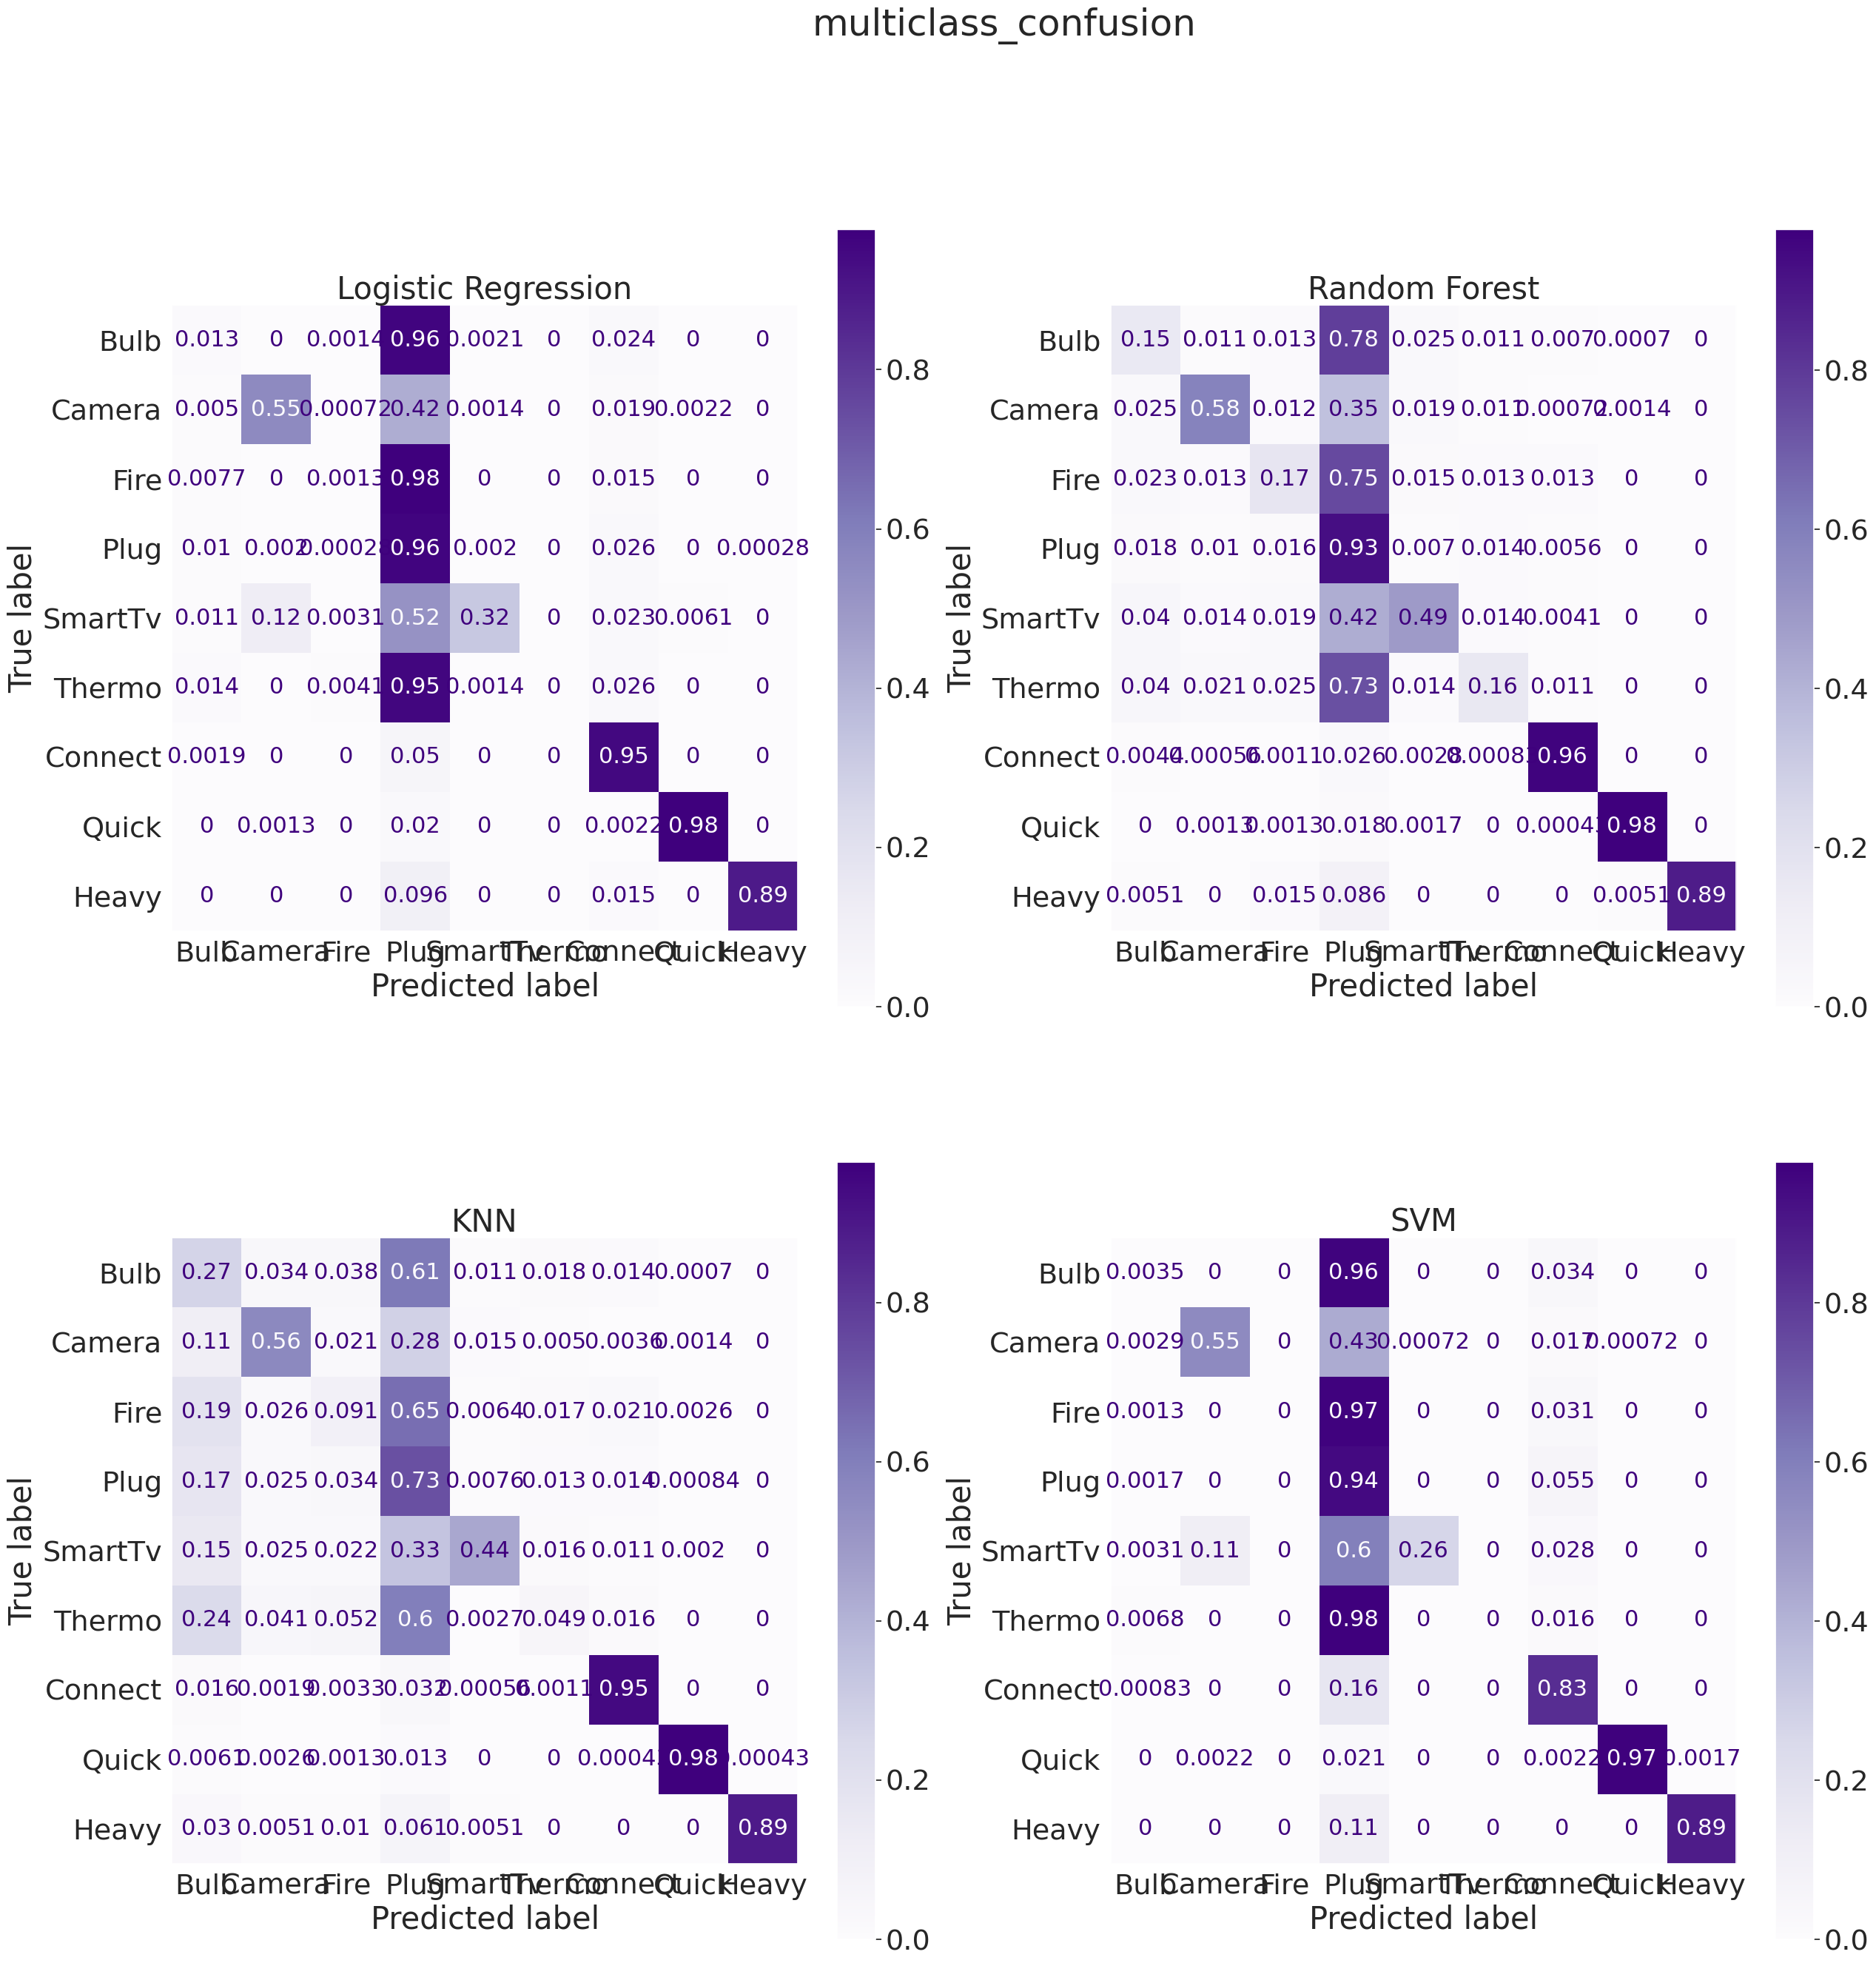

In [73]:
final, features = run_exps(X_train, y_train, X_test, y_test, "multiclass_confusion")

#### Feature importance

In [9]:
import matplotlib as mpl

def feature_importance(features, _x, img_name):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
    fig.tight_layout() 
    plt.subplots_adjust(hspace = .5)
    #import matplotlib.style
    #mpl.style.use('classic')
    #sns.set(font_scale=2)
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.suptitle("Feature importance", y=1.05, size=20)

    for (name, feat), ax in zip(features.items(), axes.flatten()):
        #for i,v in enumerate(feat.flatten()):
        #   print('Feature: %0d, Score: %.5f' % (i,v))

        ax.bar([x for x in range(len(feat.flatten()))], feat.flatten())
        ax.set_title(name)
        ax.yaxis.grid(True)
        ax.set_ylabel("Importance")
        ax.set_xticks(range(0,len(_x.columns)))
        ax.set_xticklabels(_x.columns, rotation = 90, ha="center")

    plt.savefig("images/{}.png".format(img_name))
    plt.show()

In [10]:
def draw_metrics(final, img_name):
    bootstraps = []
    for model in list(set(final.model.values)):
        model_df = final.loc[final.model == model]
        bootstrap = model_df.sample(n=30, replace=True)
        bootstraps.append(bootstrap)

    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] 

    # PERFORMANCE METRICS
    results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] 
    results_long_nofit = results_long_nofit.sort_values(by='values')

    plt.figure(figsize=(13, 6))
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
    plt.legend(loc="lower right", prop={'size': 10})
    plt.suptitle('Comparison of Model by Classification Metric: {}'.format(img_name), size=20)
    plt.grid()
    plt.savefig("images/{}.png".format(img_name))
    plt.show()

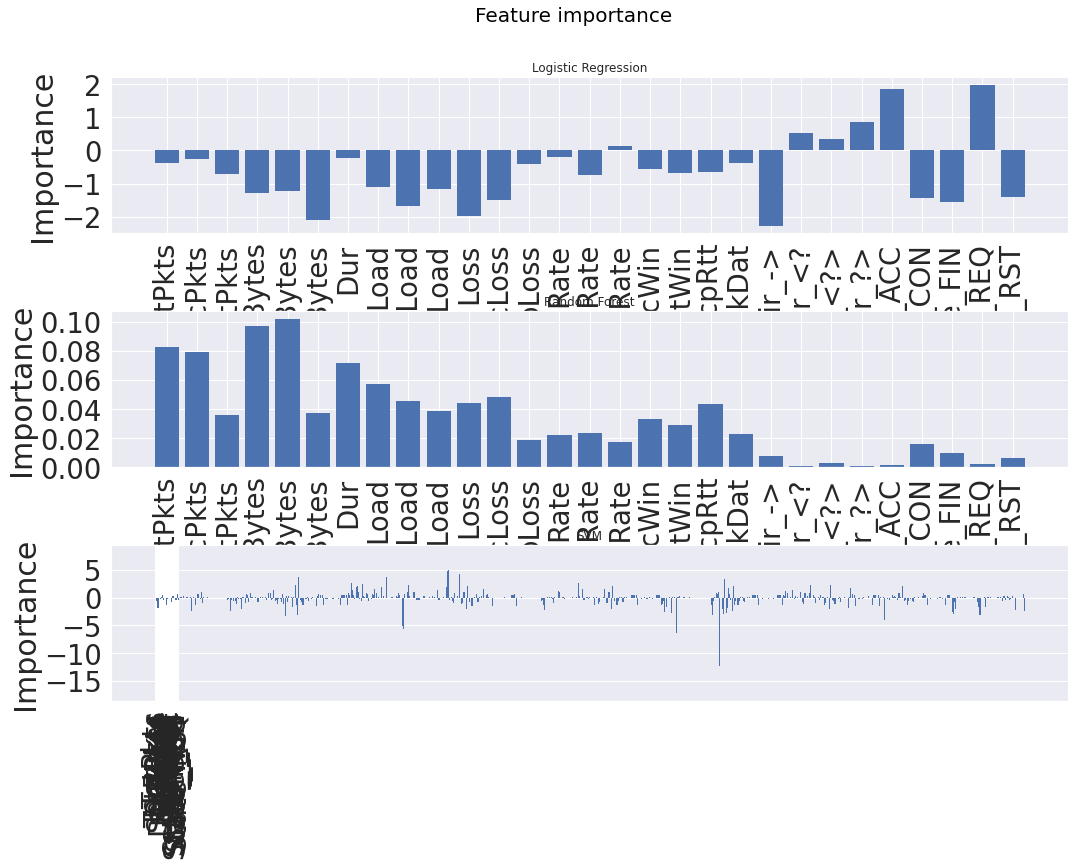

In [11]:
feature_importance(features, X, "binary_features")

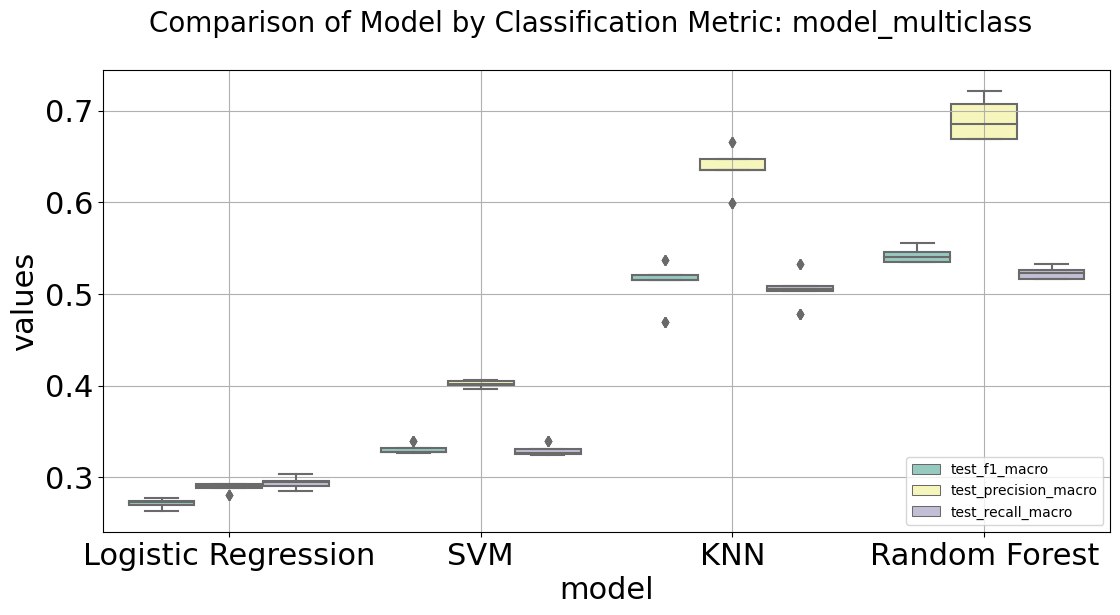

In [39]:
draw_metrics(final, "model_multiclass")

In [16]:
def model_time(final, img_name):
    bootstraps = []
    for model in list(set(final.model.values)):
        model_df = final.loc[final.model == model]
        bootstrap = model_df.sample(n=30, replace=True)
        bootstraps.append(bootstrap)

    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    results_long = pd.melt(bootstrap_df,id_vars=['model'], var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] 

    # TIME METRICS
    results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] 
    results_long_fit = results_long_fit.sort_values(by='values')
    
    averaged_time = results_long_fit.groupby(['model','metrics']).mean()
    list(averaged_time.index.get_level_values('model').unique())
    averaged_time[averaged_time.index.get_level_values('metrics') == 'fit_time'].values.flatten()
    plt.figure(figsize=(15,7))
    ax = plt.gca()
    plt.ylabel('seconds')
    total_time = (averaged_time[averaged_time.index.get_level_values('metrics') == 'fit_time'].values.flatten() + averaged_time[averaged_time.index.get_level_values('metrics') == 'score_time'].values.flatten() )
    plt.bar(list(averaged_time.index.get_level_values('model').unique()), 
            total_time, color=['r', 'g', 'b', 'y'])

    plt.suptitle("Model time")
    
    ax.yaxis.grid(True)
    plt.savefig("images/{}.png".format(img_name))
    plt.show()

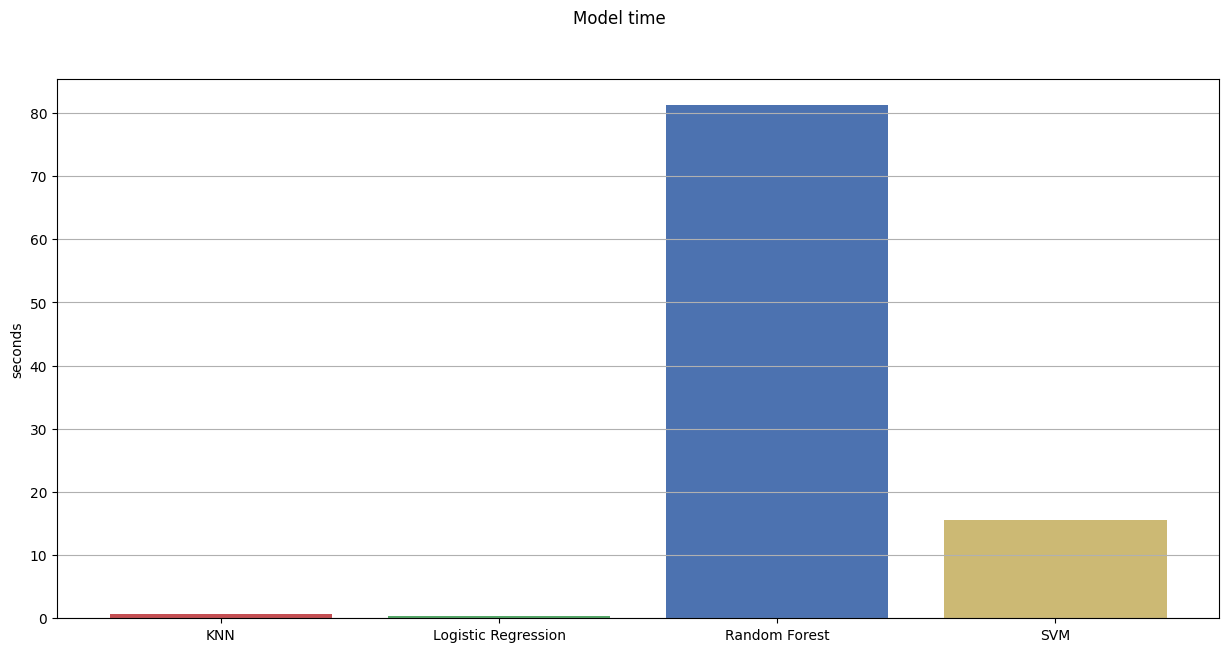

In [65]:
model_time(final, "train_fit_time")

### Only Source features

In [18]:
print(X.columns)
src_X = X[['SrcPkts', 'SrcBytes', 'SrcLoad', 'SrcLoss', 'SrcRate', 'SrcWin']]

Index(['TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes',
       'Dur', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'pLoss', 'Rate',
       'SrcRate', 'DstRate', 'SrcWin', 'DstWin', 'TcpRtt', 'AckDat', 'Dir_->',
       'Dir_<?', 'Dir_<?>', 'Dir_?>', 'State_ACC', 'State_CON', 'State_FIN',
       'State_REQ', 'State_RST'],
      dtype='object')


/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification

Model  Logistic Regression
              precision    recall  f1-score   support

        Bulb       0.00      0.00      0.00      1421
      Camera       0.92      0.52      0.67      1392
        Fire       0.00      0.00      0.00       779
        Plug       0.37      0.79      0.50      3561
     SmartTv       0.66      0.02      0.05       979
      Thermo       0.00      0.00      0.00       731
     Connect       0.68      0.78      0.72      3603
       Quick       0.92      0.97      0.95      2300
       Heavy       0.00      0.00      0.00       198

    accuracy                           0.57     14964
   macro avg       0.39      0.34      0.32     14964
weighted avg       0.52      0.57      0.50     14964



/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Random Forest
              precision    recall  f1-score   support

        Bulb       0.58      0.14      0.23      1421
      Camera       0.91      0.59      0.72      1392
        Fire       0.76      0.17      0.28       779
        Plug       0.49      0.92      0.64      3561
     SmartTv       0.89      0.47      0.62       979
      Thermo       0.65      0.18      0.28       731
     Connect       0.92      0.94      0.93      3603
       Quick       1.00      0.98      0.99      2300
       Heavy       0.98      0.89      0.93       198

    accuracy                           0.72     14964
   macro avg       0.80      0.59      0.62     14964
weighted avg       0.77      0.72      0.70     14964

Model  KNN
              precision    recall  f1-score   support

        Bulb       0.27      0.29      0.28      1421
      Camera       0.83      0.57      0.68      1392
        Fire       0.37      0.05      0.08       779
        Plug       0.47      0.75      0.58   

/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification

Model  SVM
              precision    recall  f1-score   support

        Bulb       0.00      0.00      0.00      1421
      Camera       0.91      0.55      0.69      1392
        Fire       0.00      0.00      0.00       779
        Plug       0.37      0.79      0.50      3561
     SmartTv       0.91      0.12      0.21       979
      Thermo       0.00      0.00      0.00       731
     Connect       0.70      0.78      0.74      3603
       Quick       1.00      0.97      0.98      2300
       Heavy       0.95      0.85      0.90       198

    accuracy                           0.59     14964
   macro avg       0.54      0.45      0.45     14964
weighted avg       0.57      0.59      0.54     14964



/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


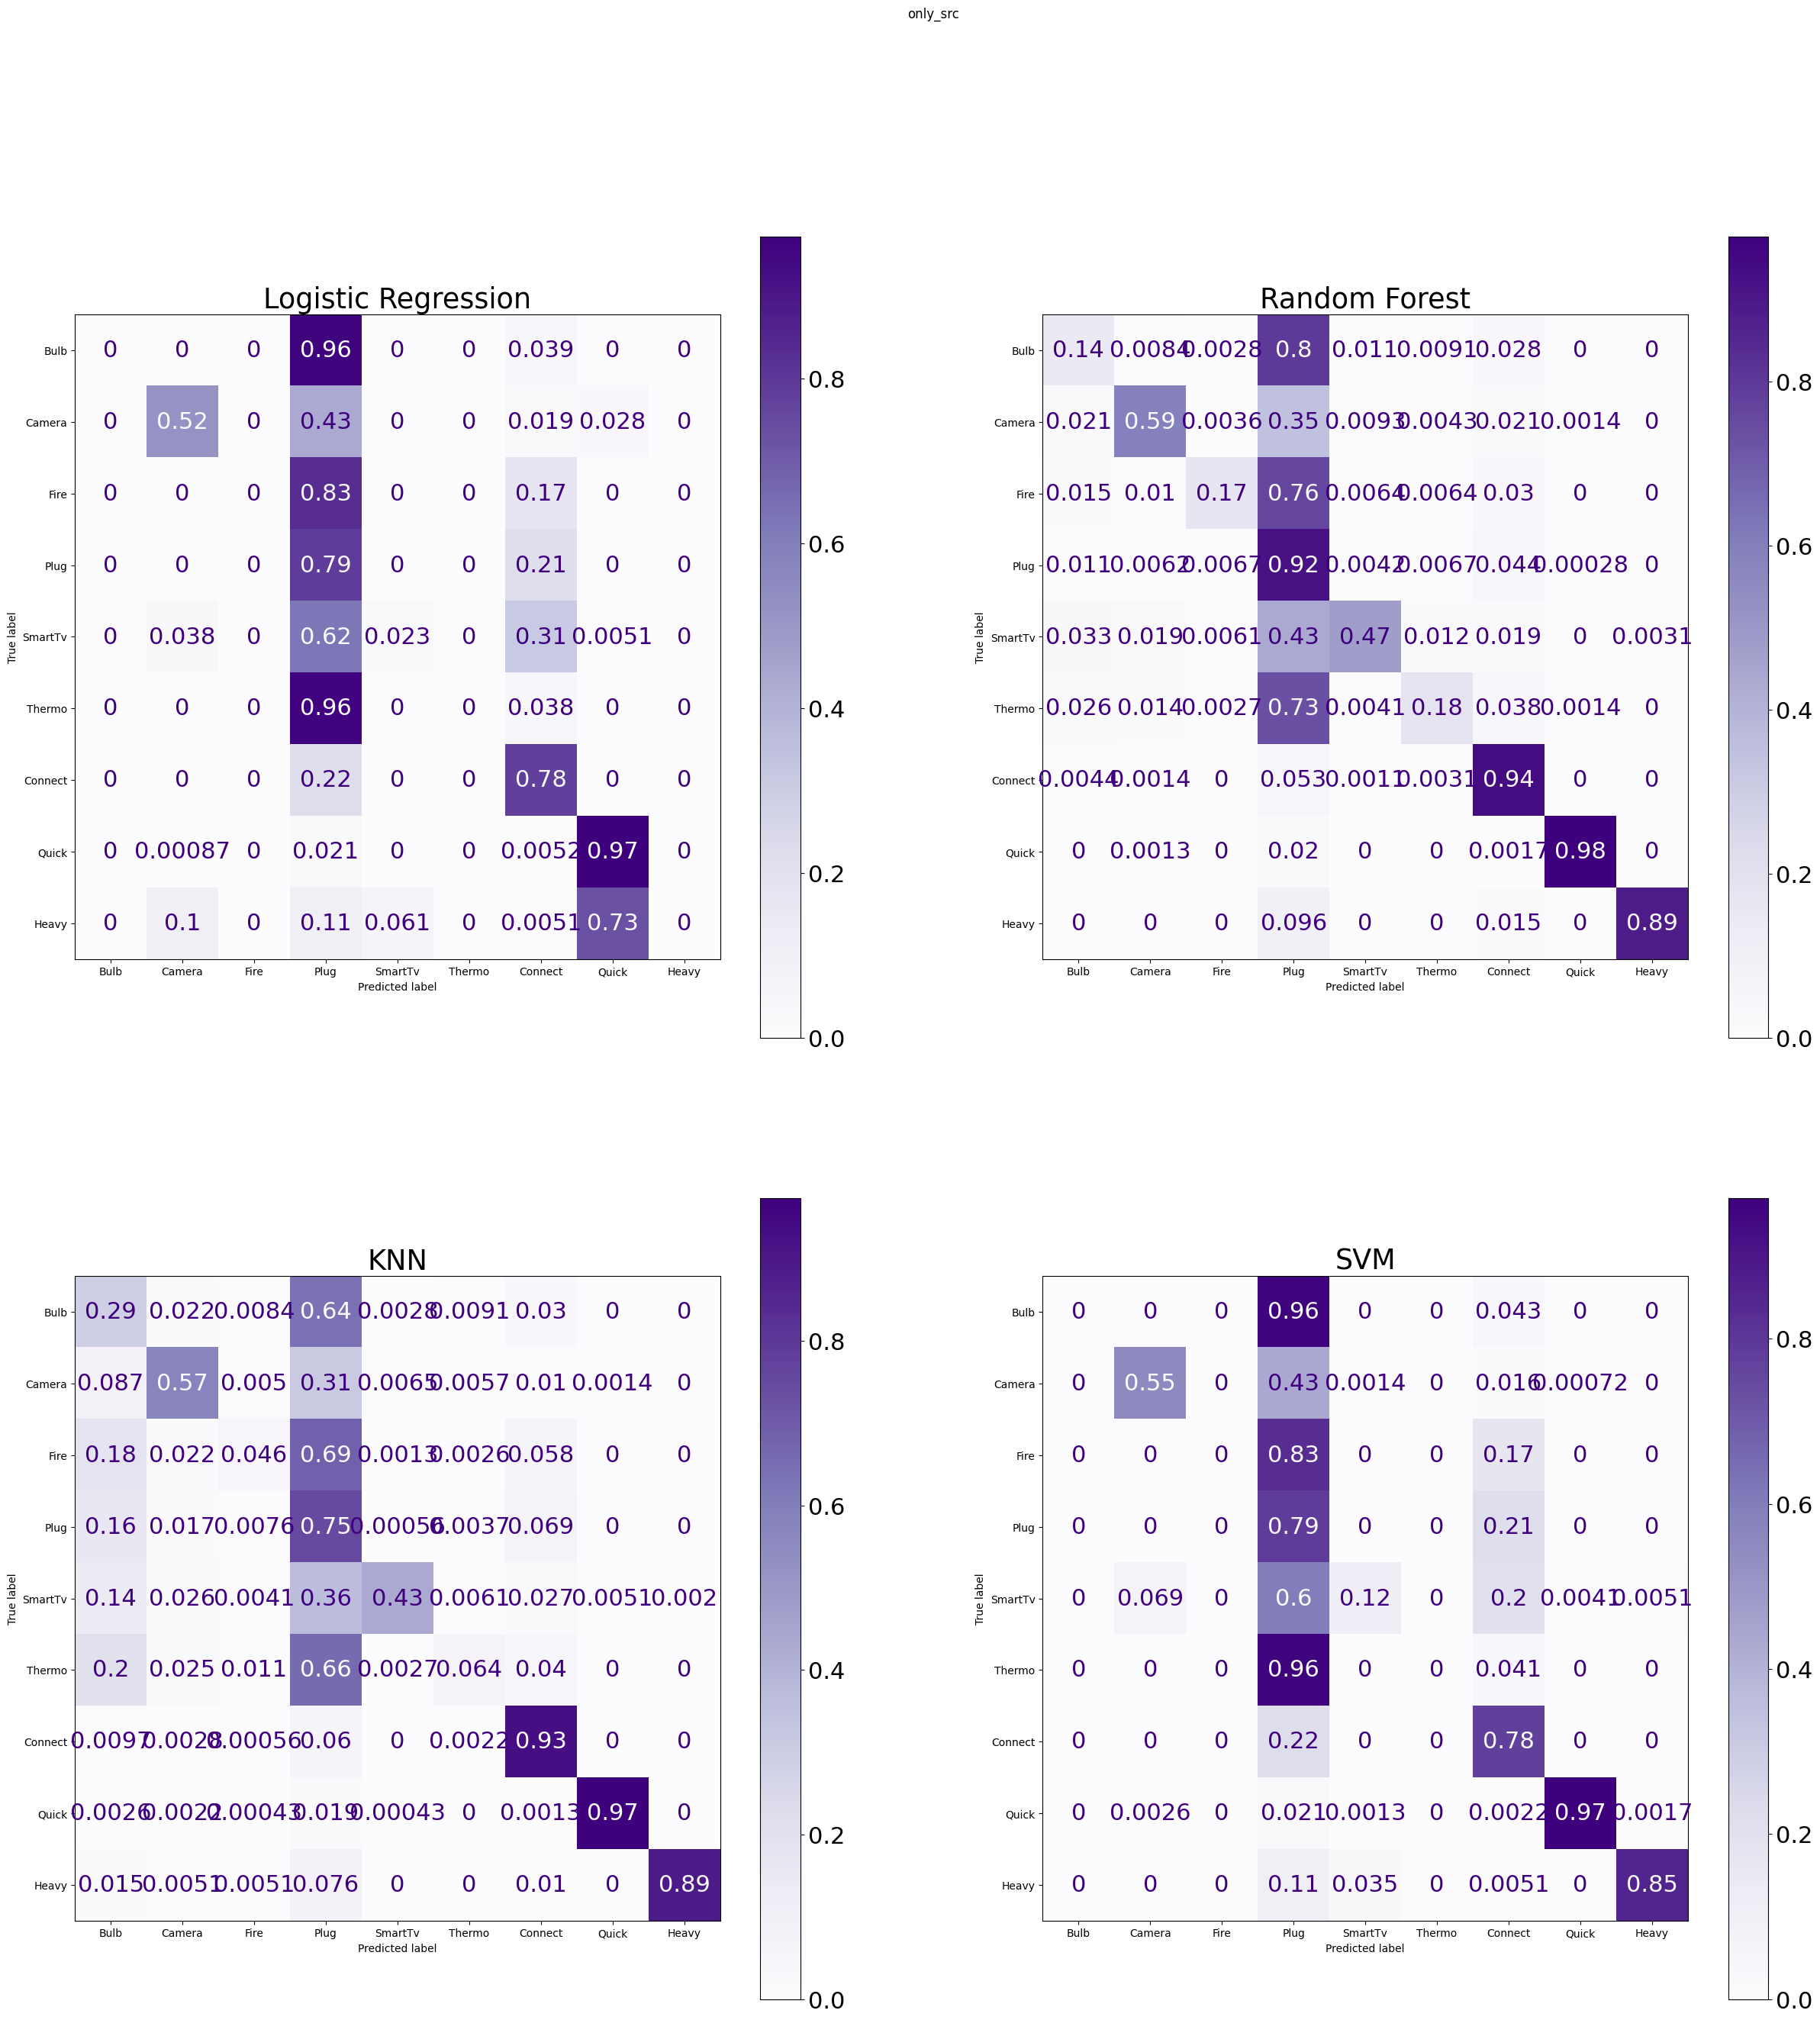

In [19]:
X_train, X_test, y_train, y_test = train_test_split(src_X, y, test_size=0.40, random_state=8675309, shuffle=True)
final_src, features_src = run_exps(X_train, y_train, X_test, y_test, "only_src")

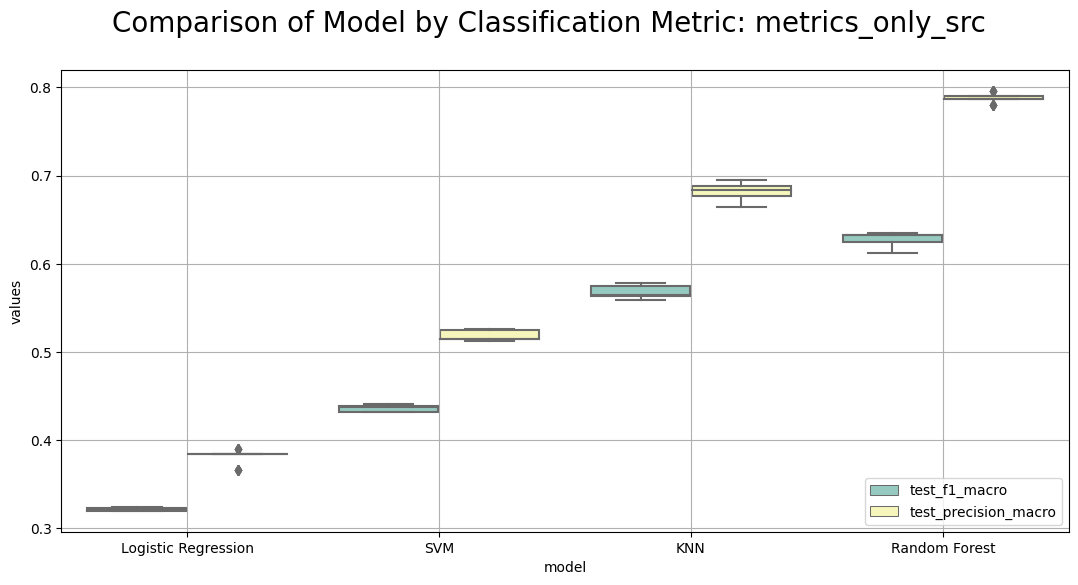

In [22]:
draw_metrics(final_src, "metrics_only_src")

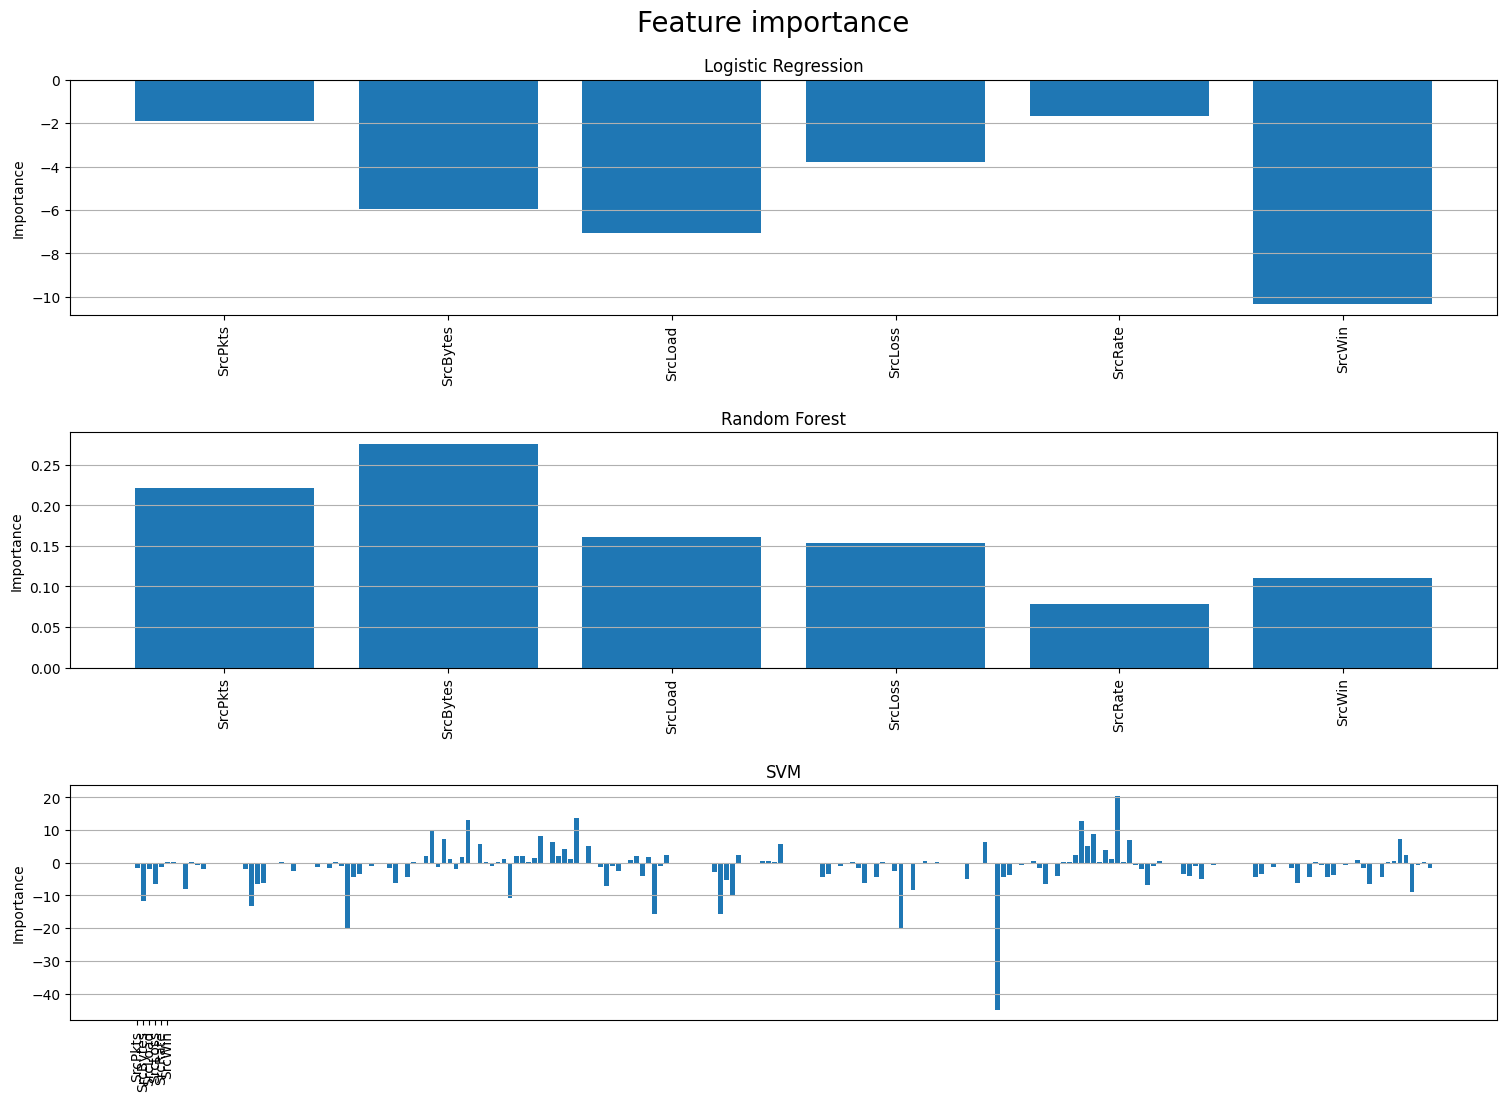

In [23]:
feature_importance(features_src, src_X, "only_src_features")

### Only Destination features

In [24]:
dst_X = X[['DstPkts', 'DstBytes', 'DstLoad', 'DstRate', 'DstWin']]

/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification

Model  Logistic Regression
              precision    recall  f1-score   support

        Bulb       0.00      0.00      0.00      1421
      Camera       0.62      0.53      0.57      1392
        Fire       0.00      0.00      0.00       779
        Plug       0.32      0.89      0.48      3561
     SmartTv       0.00      0.00      0.00       979
      Thermo       0.00      0.00      0.00       731
     Connect       0.72      0.42      0.53      3603
       Quick       0.95      0.80      0.87      2300
       Heavy       0.00      0.00      0.00       198

    accuracy                           0.48     14964
   macro avg       0.29      0.29      0.27     14964
weighted avg       0.45      0.48      0.43     14964



/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Random Forest
              precision    recall  f1-score   support

        Bulb       0.41      0.04      0.07      1421
      Camera       0.96      0.56      0.71      1392
        Fire       0.29      0.05      0.08       779
        Plug       0.43      0.94      0.59      3561
     SmartTv       0.94      0.45      0.61       979
      Thermo       0.26      0.03      0.06       731
     Connect       0.95      0.89      0.92      3603
       Quick       1.00      0.83      0.91      2300
       Heavy       0.99      0.87      0.93       198

    accuracy                           0.67     14964
   macro avg       0.69      0.52      0.54     14964
weighted avg       0.71      0.67      0.63     14964

Model  KNN
              precision    recall  f1-score   support

        Bulb       0.29      0.07      0.12      1421
      Camera       0.90      0.53      0.67      1392
        Fire       0.23      0.04      0.07       779
        Plug       0.45      0.92      0.60   

/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification

Model  SVM
              precision    recall  f1-score   support

        Bulb       0.00      0.00      0.00      1421
      Camera       0.71      0.52      0.60      1392
        Fire       0.00      0.00      0.00       779
        Plug       0.33      0.83      0.47      3561
     SmartTv       0.87      0.24      0.38       979
      Thermo       0.00      0.00      0.00       731
     Connect       0.68      0.55      0.60      3603
       Quick       0.98      0.79      0.88      2300
       Heavy       0.00      0.00      0.00       198

    accuracy                           0.51     14964
   macro avg       0.40      0.33      0.33     14964
weighted avg       0.52      0.51      0.47     14964



/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


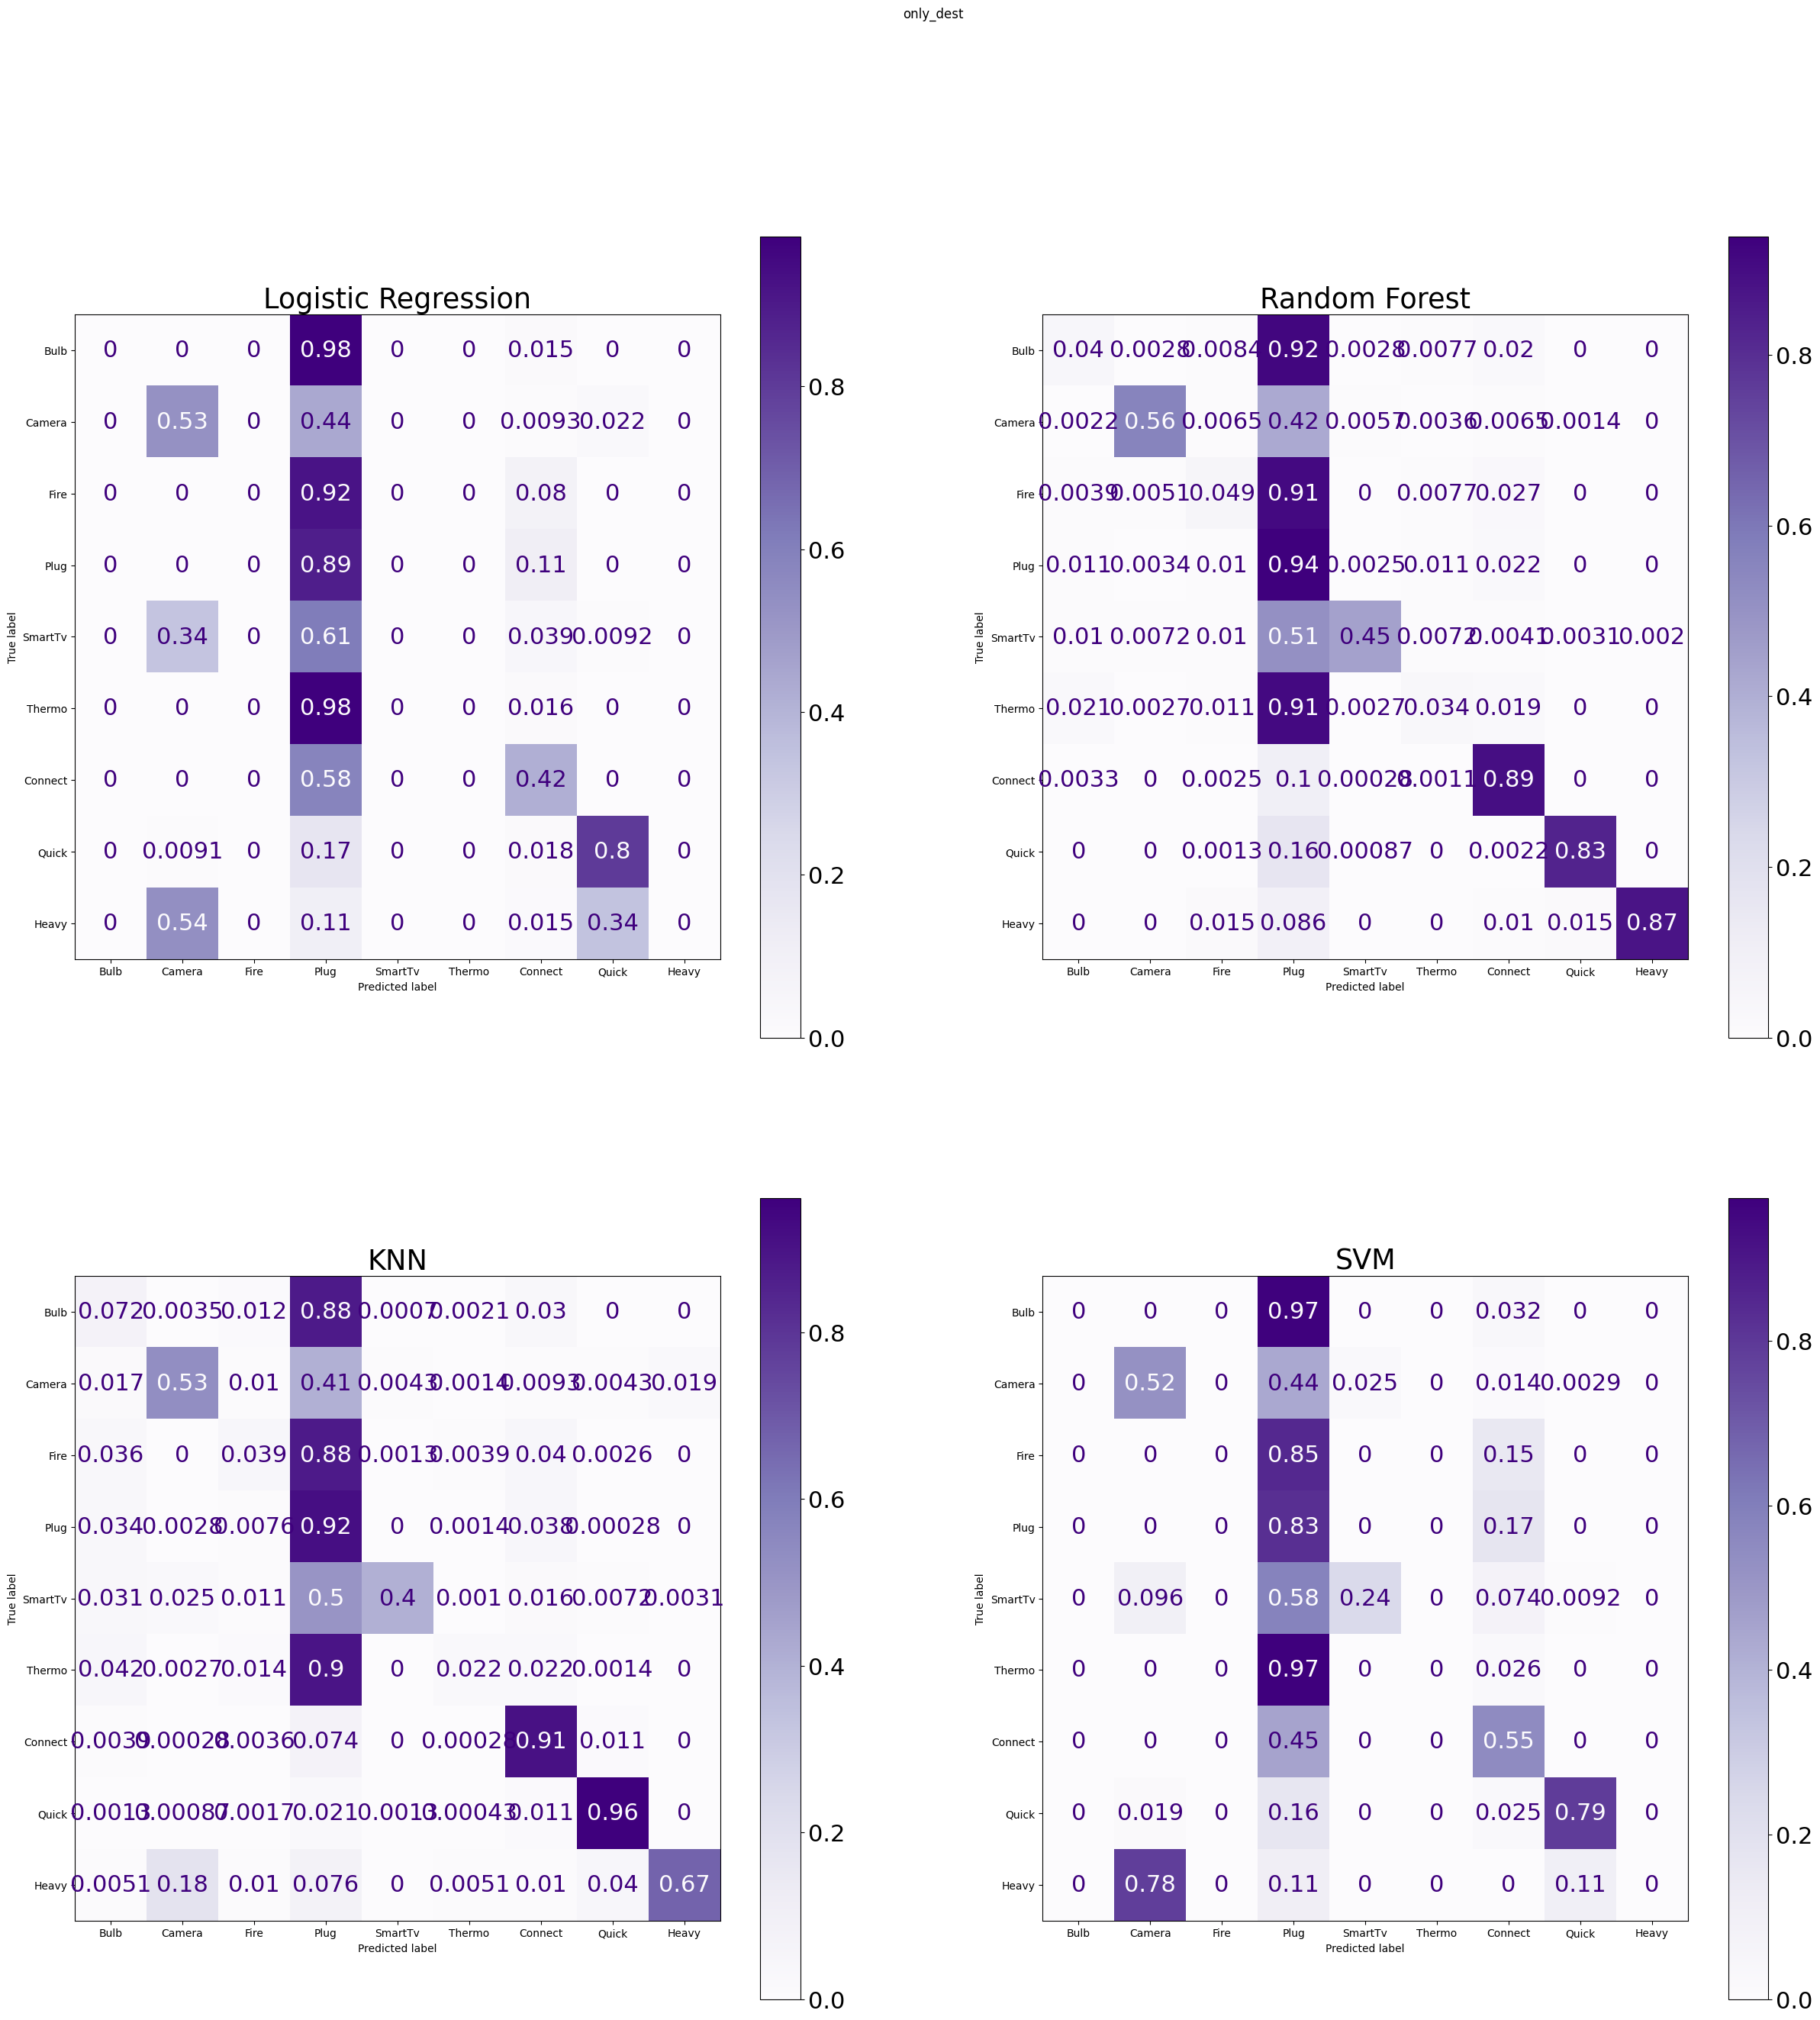

In [25]:
X_train, X_test, y_train, y_test = train_test_split(dst_X, y, test_size=0.40, random_state=8675309, shuffle=True)
final_dst, features_dst = run_exps(X_train, y_train, X_test, y_test, "only_dest")

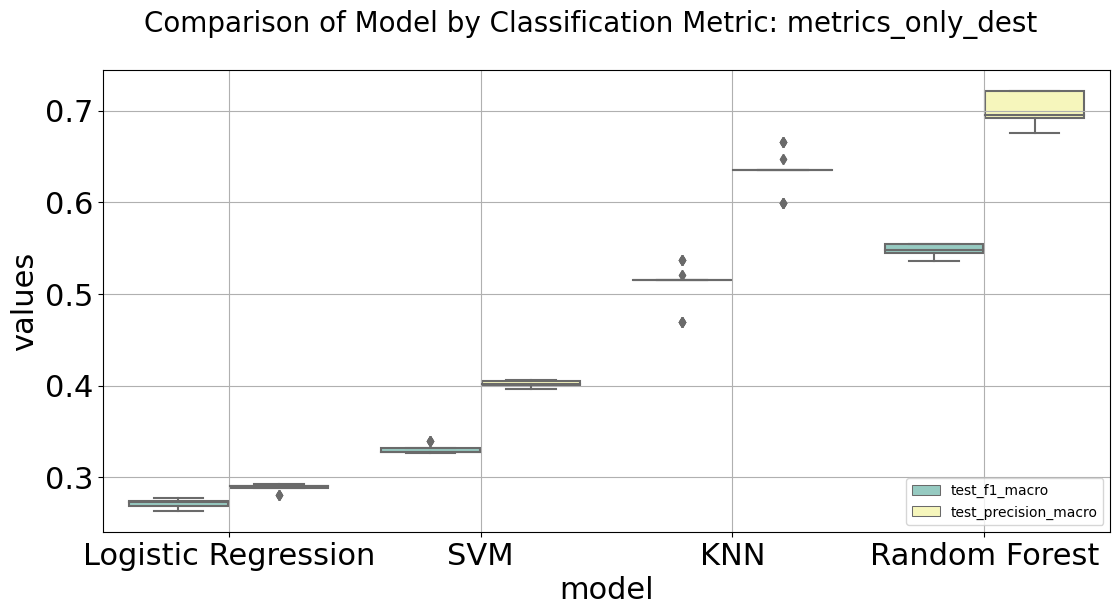

In [26]:
draw_metrics(final_dst, "metrics_only_dest")

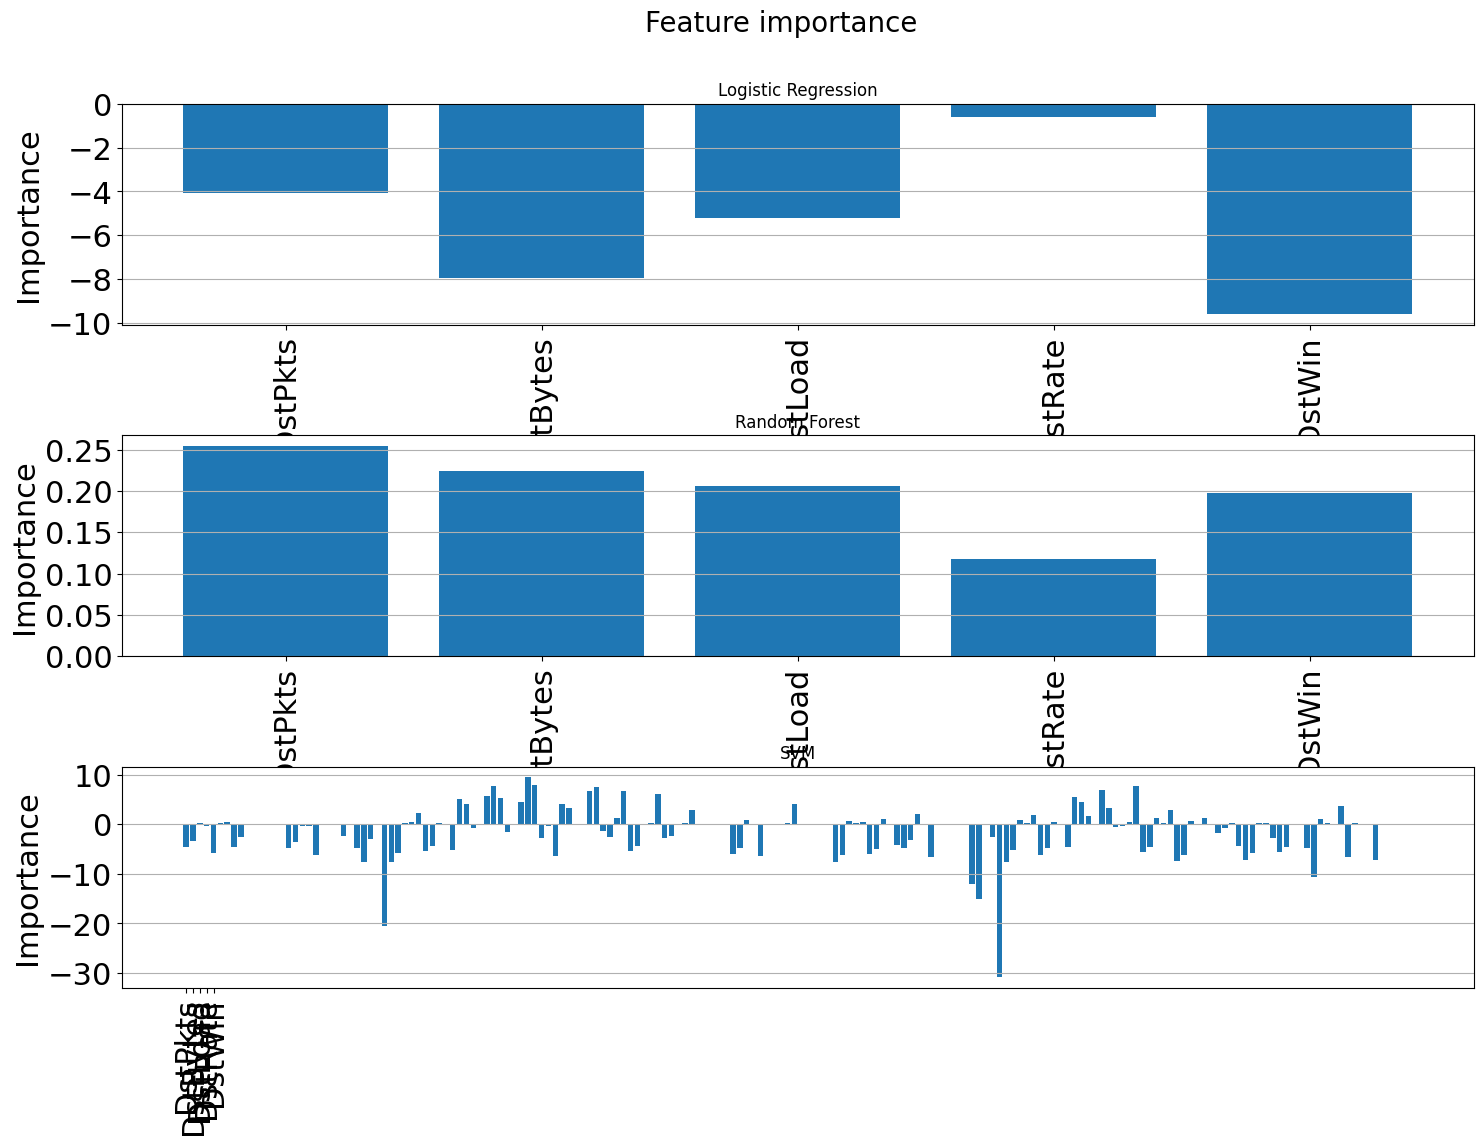

In [27]:
feature_importance(features_dst, dst_X, "only_dest_features")

In [41]:
best_X = X[['DstPkts', 'DstBytes', 'Loss', 'State_REQ', 'State_FIN', 'DstWin', 'AckDat']]

/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification

Model  Logistic Regression
              precision    recall  f1-score   support

        Bulb       0.00      0.00      0.00      1421
      Camera       0.62      0.53      0.57      1392
        Fire       0.00      0.00      0.00       779
        Plug       0.39      0.96      0.56      3561
     SmartTv       0.00      0.00      0.00       979
      Thermo       0.00      0.00      0.00       731
     Connect       0.85      0.71      0.77      3603
       Quick       0.94      0.86      0.90      2300
       Heavy       0.00      0.00      0.00       198

    accuracy                           0.58     14964
   macro avg       0.31      0.34      0.31     14964
weighted avg       0.50      0.58      0.51     14964



/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Random Forest
              precision    recall  f1-score   support

        Bulb       0.47      0.05      0.09      1421
      Camera       0.93      0.56      0.70      1392
        Fire       0.64      0.13      0.21       779
        Plug       0.45      0.97      0.62      3561
     SmartTv       0.94      0.46      0.61       979
      Thermo       0.56      0.03      0.06       731
     Connect       0.98      0.93      0.96      3603
       Quick       1.00      0.90      0.95      2300
       Heavy       1.00      0.84      0.92       198

    accuracy                           0.70     14964
   macro avg       0.78      0.54      0.57     14964
weighted avg       0.76      0.70      0.66     14964

Model  KNN
              precision    recall  f1-score   support

        Bulb       0.20      0.47      0.28      1421
      Camera       0.94      0.54      0.69      1392
        Fire       0.48      0.10      0.17       779
        Plug       0.51      0.61      0.55   

/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification

Model  SVM
              precision    recall  f1-score   support

        Bulb       0.00      0.00      0.00      1421
      Camera       0.76      0.54      0.63      1392
        Fire       0.00      0.00      0.00       779
        Plug       0.39      0.98      0.56      3561
     SmartTv       0.98      0.28      0.43       979
      Thermo       0.00      0.00      0.00       731
     Connect       0.86      0.65      0.74      3603
       Quick       0.97      0.86      0.91      2300
       Heavy       0.00      0.00      0.00       198

    accuracy                           0.59     14964
   macro avg       0.44      0.37      0.36     14964
weighted avg       0.58      0.59      0.54     14964



/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


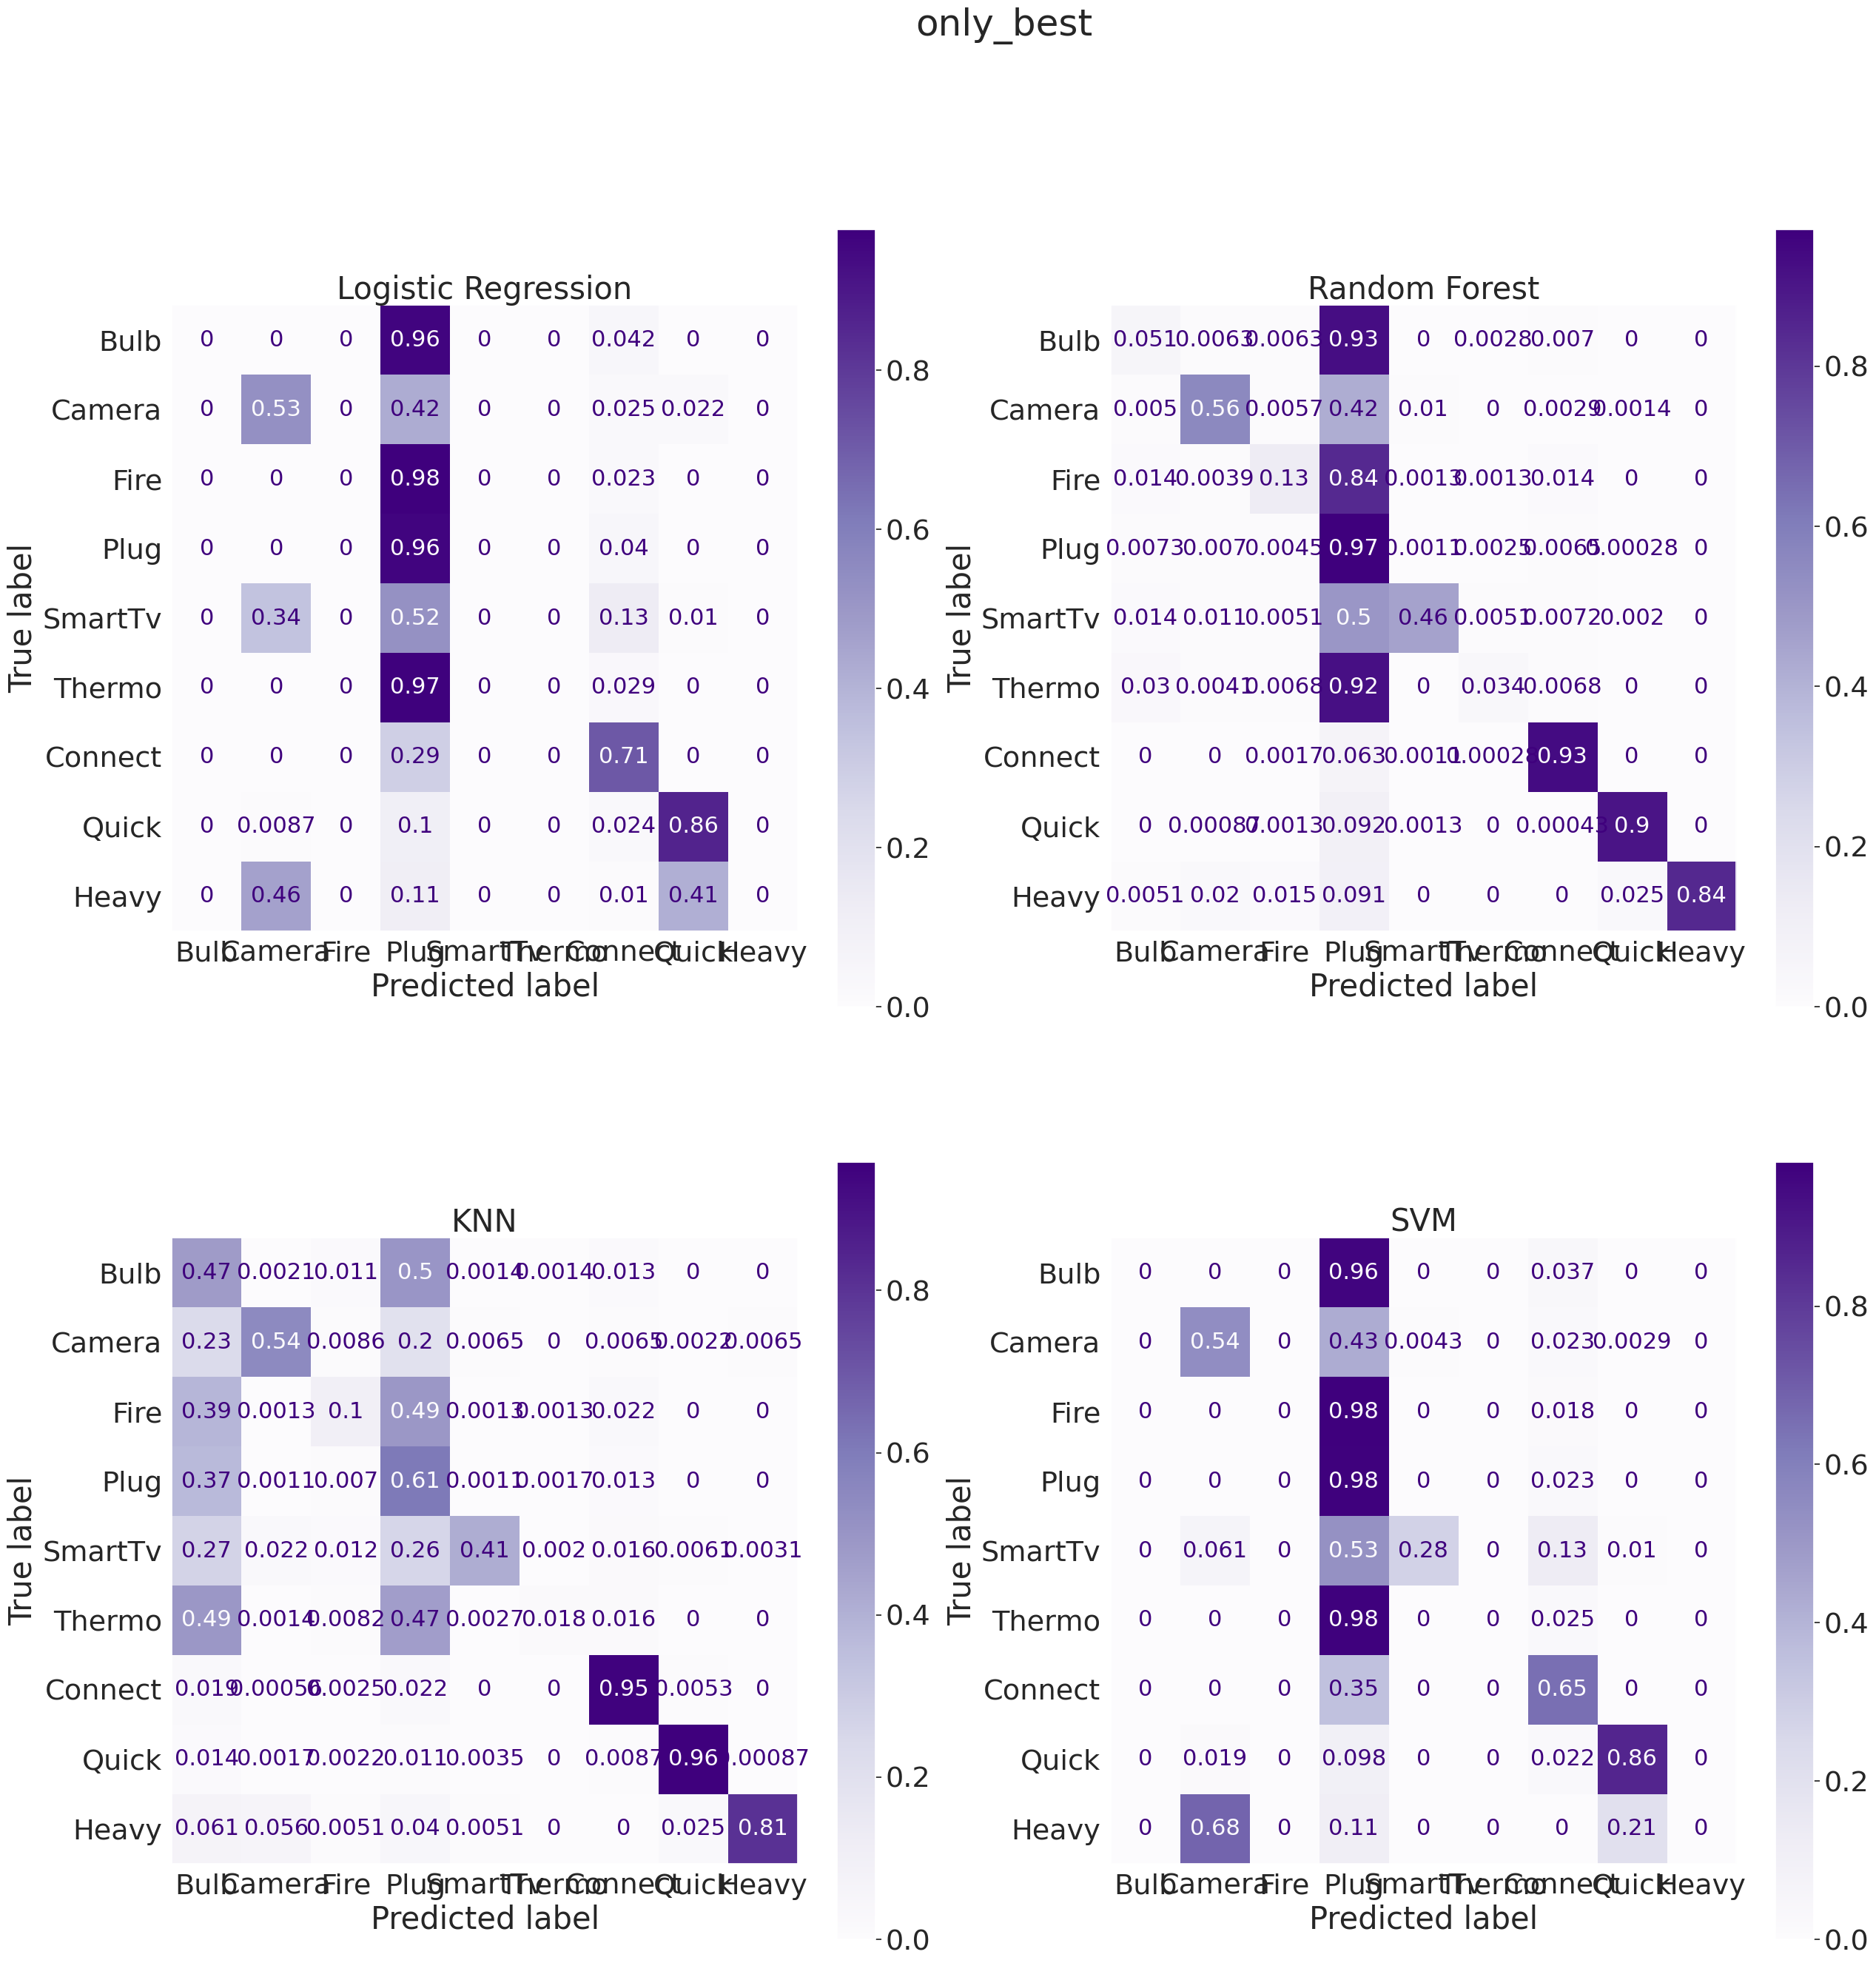

In [50]:
X_train, X_test, y_train, y_test = train_test_split(best_X, y, test_size=0.40, random_state=8675309, shuffle=True)
final_best, features_best = run_exps(X_train, y_train, X_test, y_test, "only_best")

### No tuning

In [ ]:
models = [
          ('Logistic Regression', LogisticRegression()), 
          ('Random Forest', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
        ]

In [47]:
nohyper_X = X

/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Logistic Regression
              precision    recall  f1-score   support

        Bulb       0.16      0.01      0.02      1421
      Camera       0.86      0.55      0.67      1392
        Fire       0.00      0.00      0.00       779
        Plug       0.43      0.89      0.58      3561
     SmartTv       0.99      0.25      0.39       979
      Thermo       0.40      0.00      0.01       731
     Connect       0.83      0.90      0.86      3603
       Quick       1.00      0.97      0.98      2300
       Heavy       0.98      0.88      0.93       198

    accuracy                           0.66     14964
   macro avg       0.63      0.49      0.49     14964
weighted avg       0.65      0.66      0.60     14964

Model  Random Forest
              precision    recall  f1-score   support

        Bulb       0.50      0.15      0.23      1421
      Camera       0.89      0.58      0.70      1392
        Fire       0.51      0.17      0.26       779
        Plug       0.50      0

/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification

Model  SVM
              precision    recall  f1-score   support

        Bulb       0.19      0.00      0.01      1421
      Camera       0.87      0.55      0.67      1392
        Fire       0.00      0.00      0.00       779
        Plug       0.42      0.94      0.58      3561
     SmartTv       1.00      0.26      0.41       979
      Thermo       0.00      0.00      0.00       731
     Connect       0.90      0.83      0.87      3603
       Quick       1.00      0.97      0.99      2300
       Heavy       0.98      0.89      0.93       198

    accuracy                           0.66     14964
   macro avg       0.59      0.49      0.50     14964
weighted avg       0.65      0.66      0.60     14964



/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antedo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


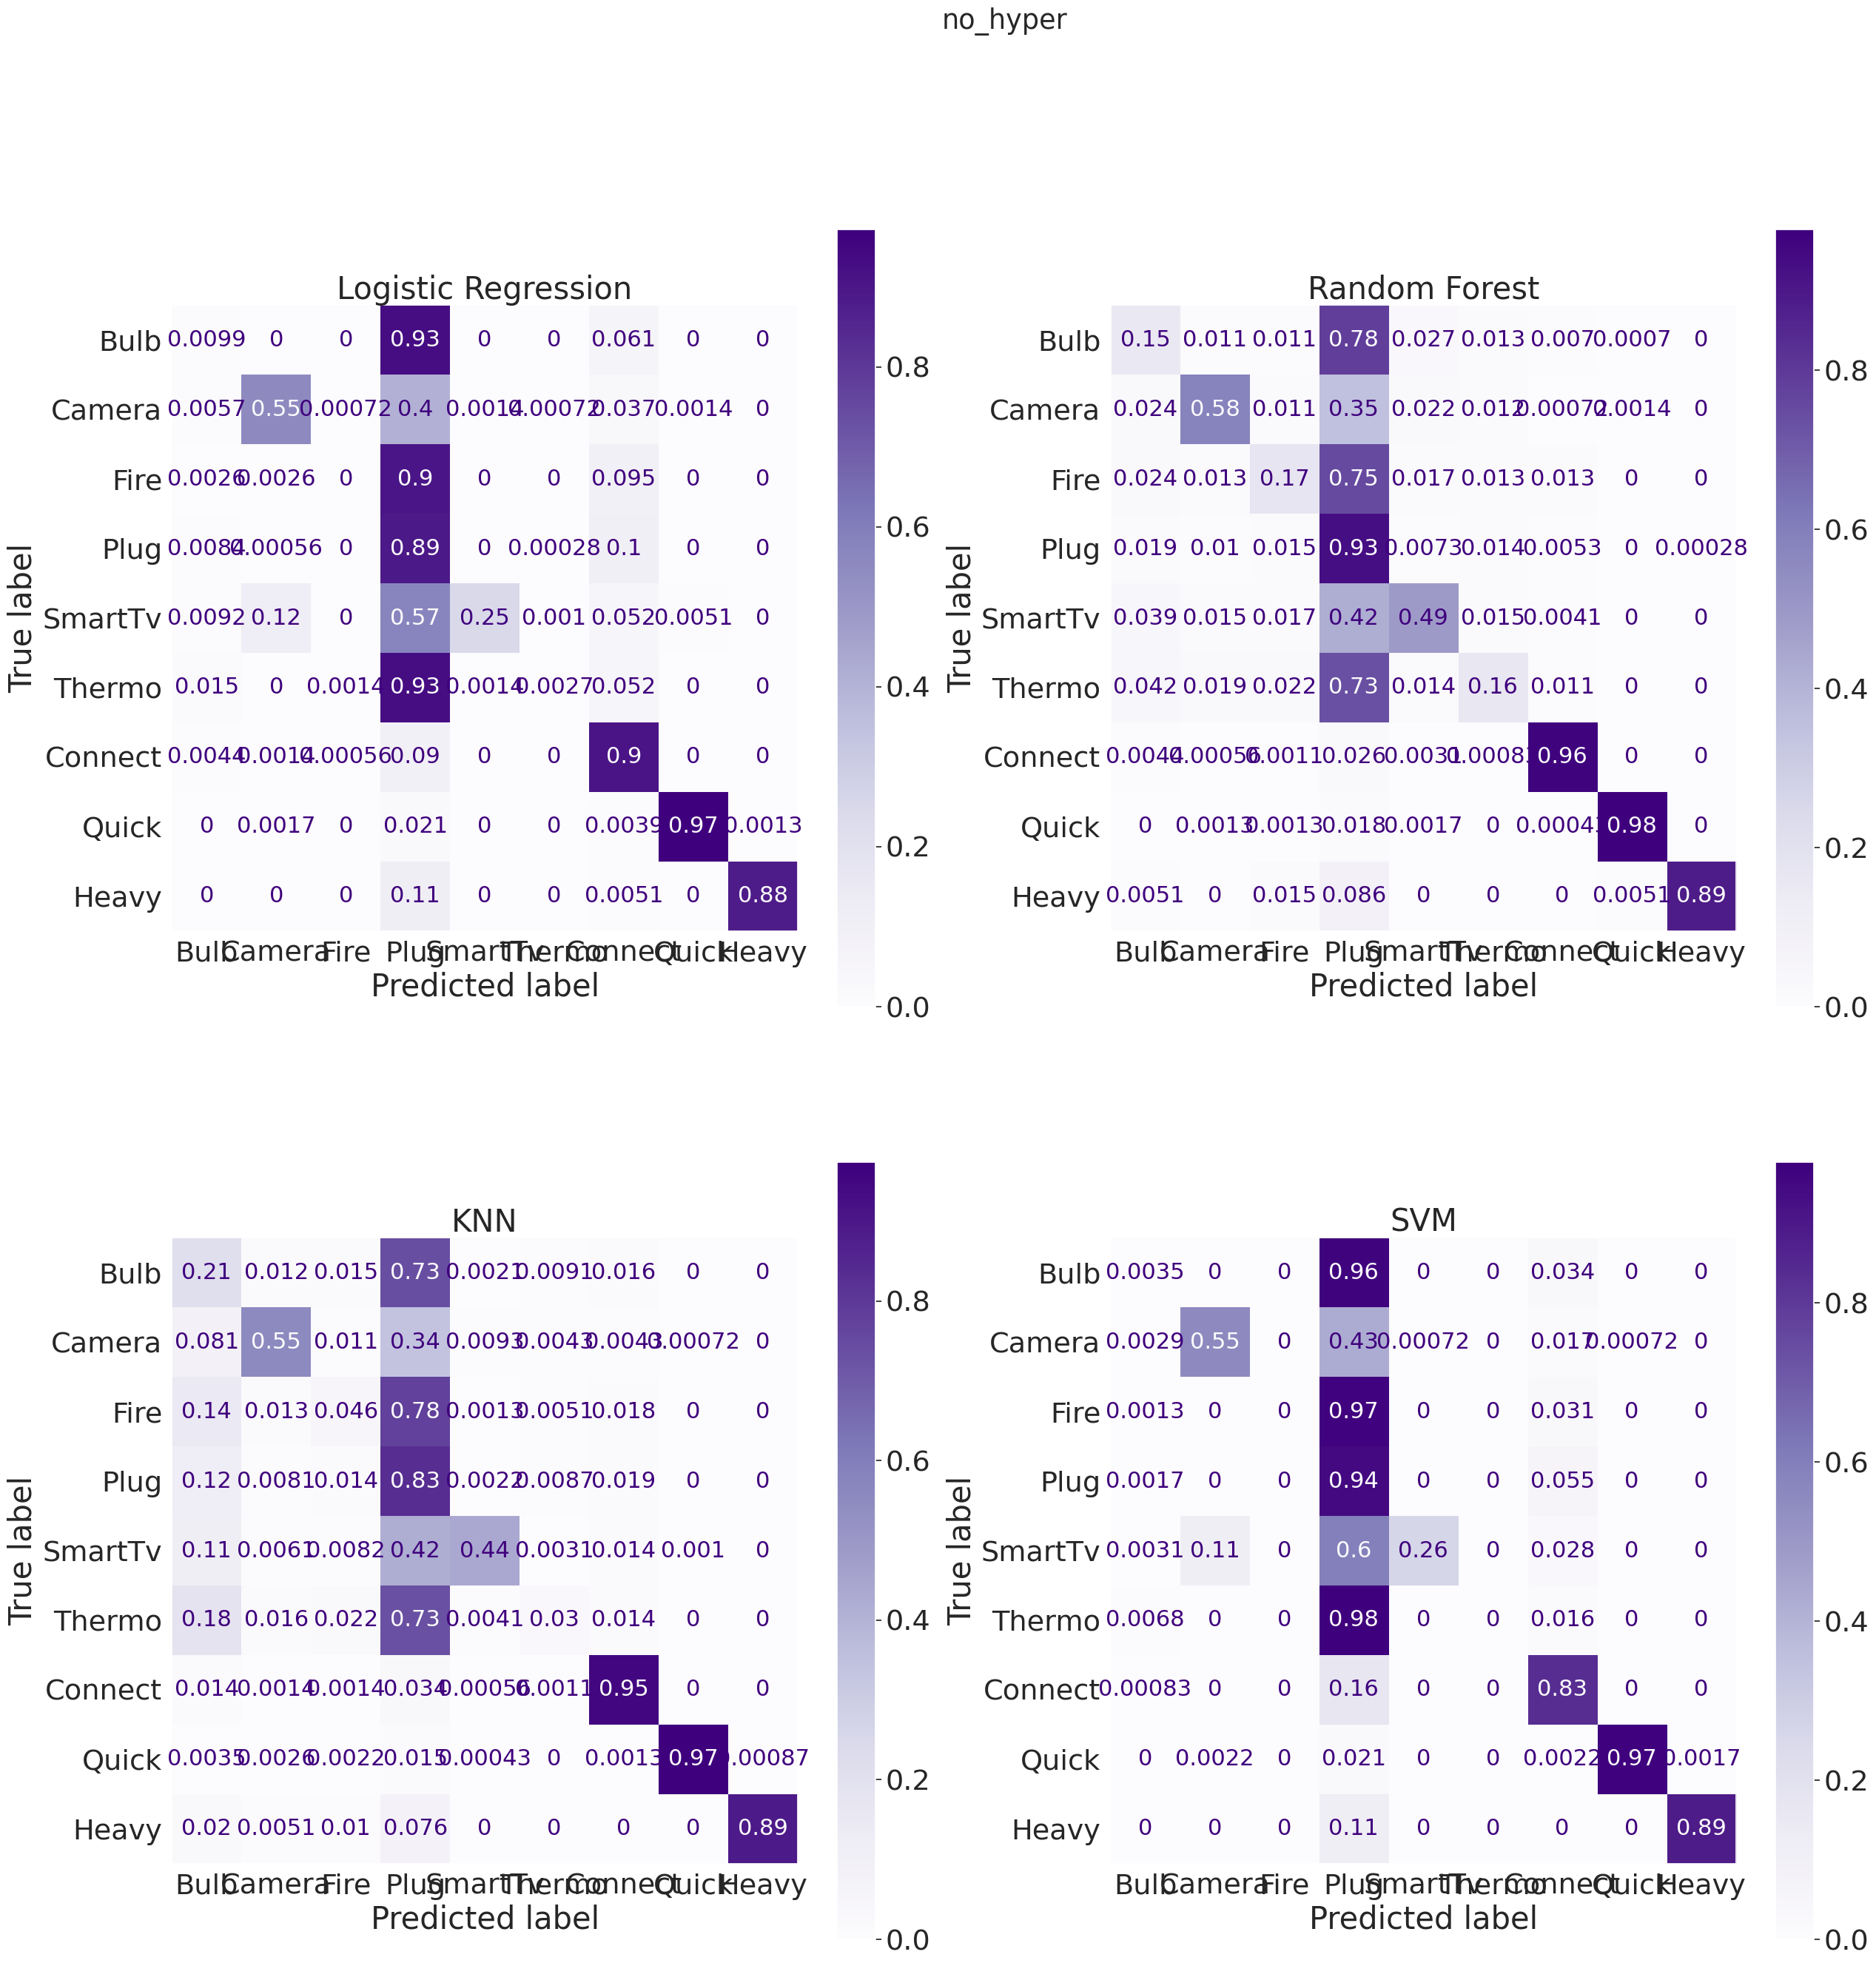

In [52]:
X_train, X_test, y_train, y_test = train_test_split(nohyper_X, y, test_size=0.40, random_state=8675309, shuffle=True)
final_nohyper, features_nohyper = run_exps(X_train, y_train, X_test, y_test, "no_hyper")

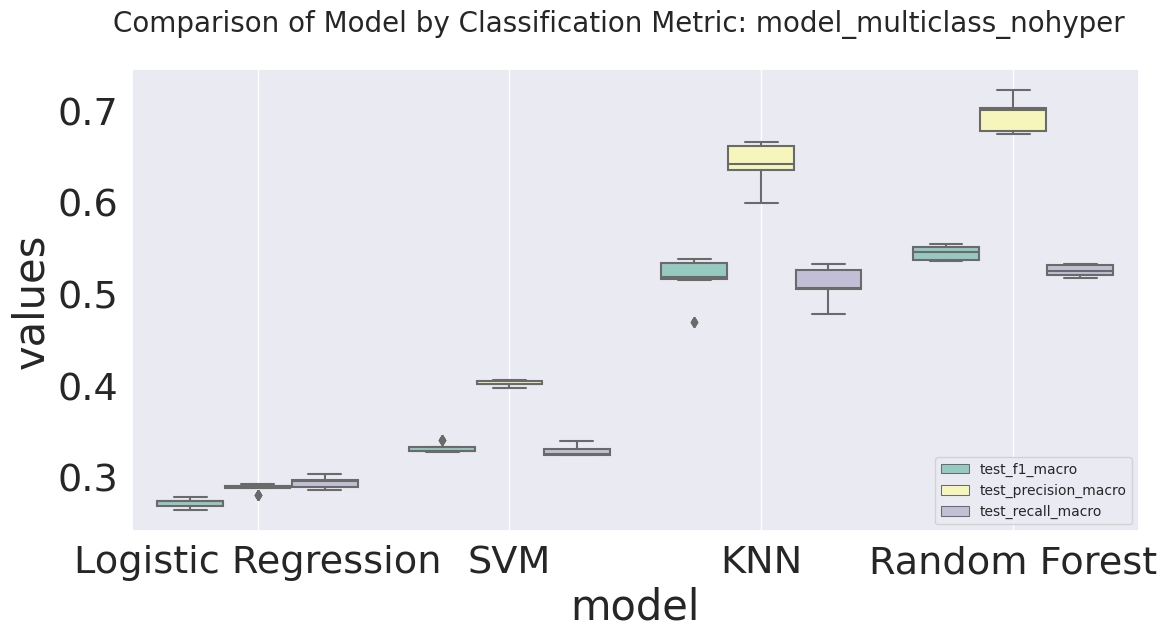

In [63]:
draw_metrics(final, "model_multiclass_nohyper")

In [58]:
merged_results = pd.DataFrame()

merged_results["all"] = final.groupby("model").mean()["test_f1_macro"]
merged_results["src"] = final_src.groupby("model").mean()["test_f1_macro"]
merged_results["dst"] = final_dst.groupby("model").mean()["test_f1_macro"]
merged_results["best"] = final_best.groupby("model").mean()["test_f1_macro"]
merged_results["no_hyper"] = final_nohyper.groupby("model").mean()["test_f1_macro"]
merged_results["all_std"] = final.groupby("model").std()["test_f1_macro"]
merged_results["src_std"] = final_src.groupby("model").std()["test_f1_macro"]
merged_results["dst_std"] = final_dst.groupby("model").std()["test_f1_macro"]
merged_results["best_std"] = final_best.groupby("model").std()["test_f1_macro"]

merged_results

,all,src,dst,best,no_hyper,all_std,src_std,dst_std,best_std
model,,,,,,,,,
KNN,0.511638,0.566667,0.511638,0.556630,0.570625,0.025264,0.006959,0.025264,0.011037
Logistic Regression,0.271346,0.321999,0.271346,0.310250,0.497044,0.005526,0.001587,0.005526,0.002913
Random Forest,0.544653,0.624706,0.544190,0.569137,0.621412,0.008167,0.009655,0.007579,0.009628
SVM,0.330878,0.437056,0.330878,0.364223,0.500569,0.005441,0.003621,0.005441,0.006245


### Learning curves 

In [68]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), score=None, img_name=None):
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, 
                                                                          X, y, cv=cv, n_jobs=n_jobs,
                                                                           train_sizes=train_sizes,
                                                                           return_times=True,  scoring=score)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(score)
    
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best", prop={'size': 6})
    
    plt.suptitle(img_name)
    plt.savefig("images/{}.png".format(img_name))
    return plt

Logistic Regression learning curves started
Split done
DONE!
--------------------

Random Forest learning curves started
Split done
DONE!
--------------------

KNN learning curves started
Split done
DONE!
--------------------

SVM learning curves started
Split done
DONE!
--------------------



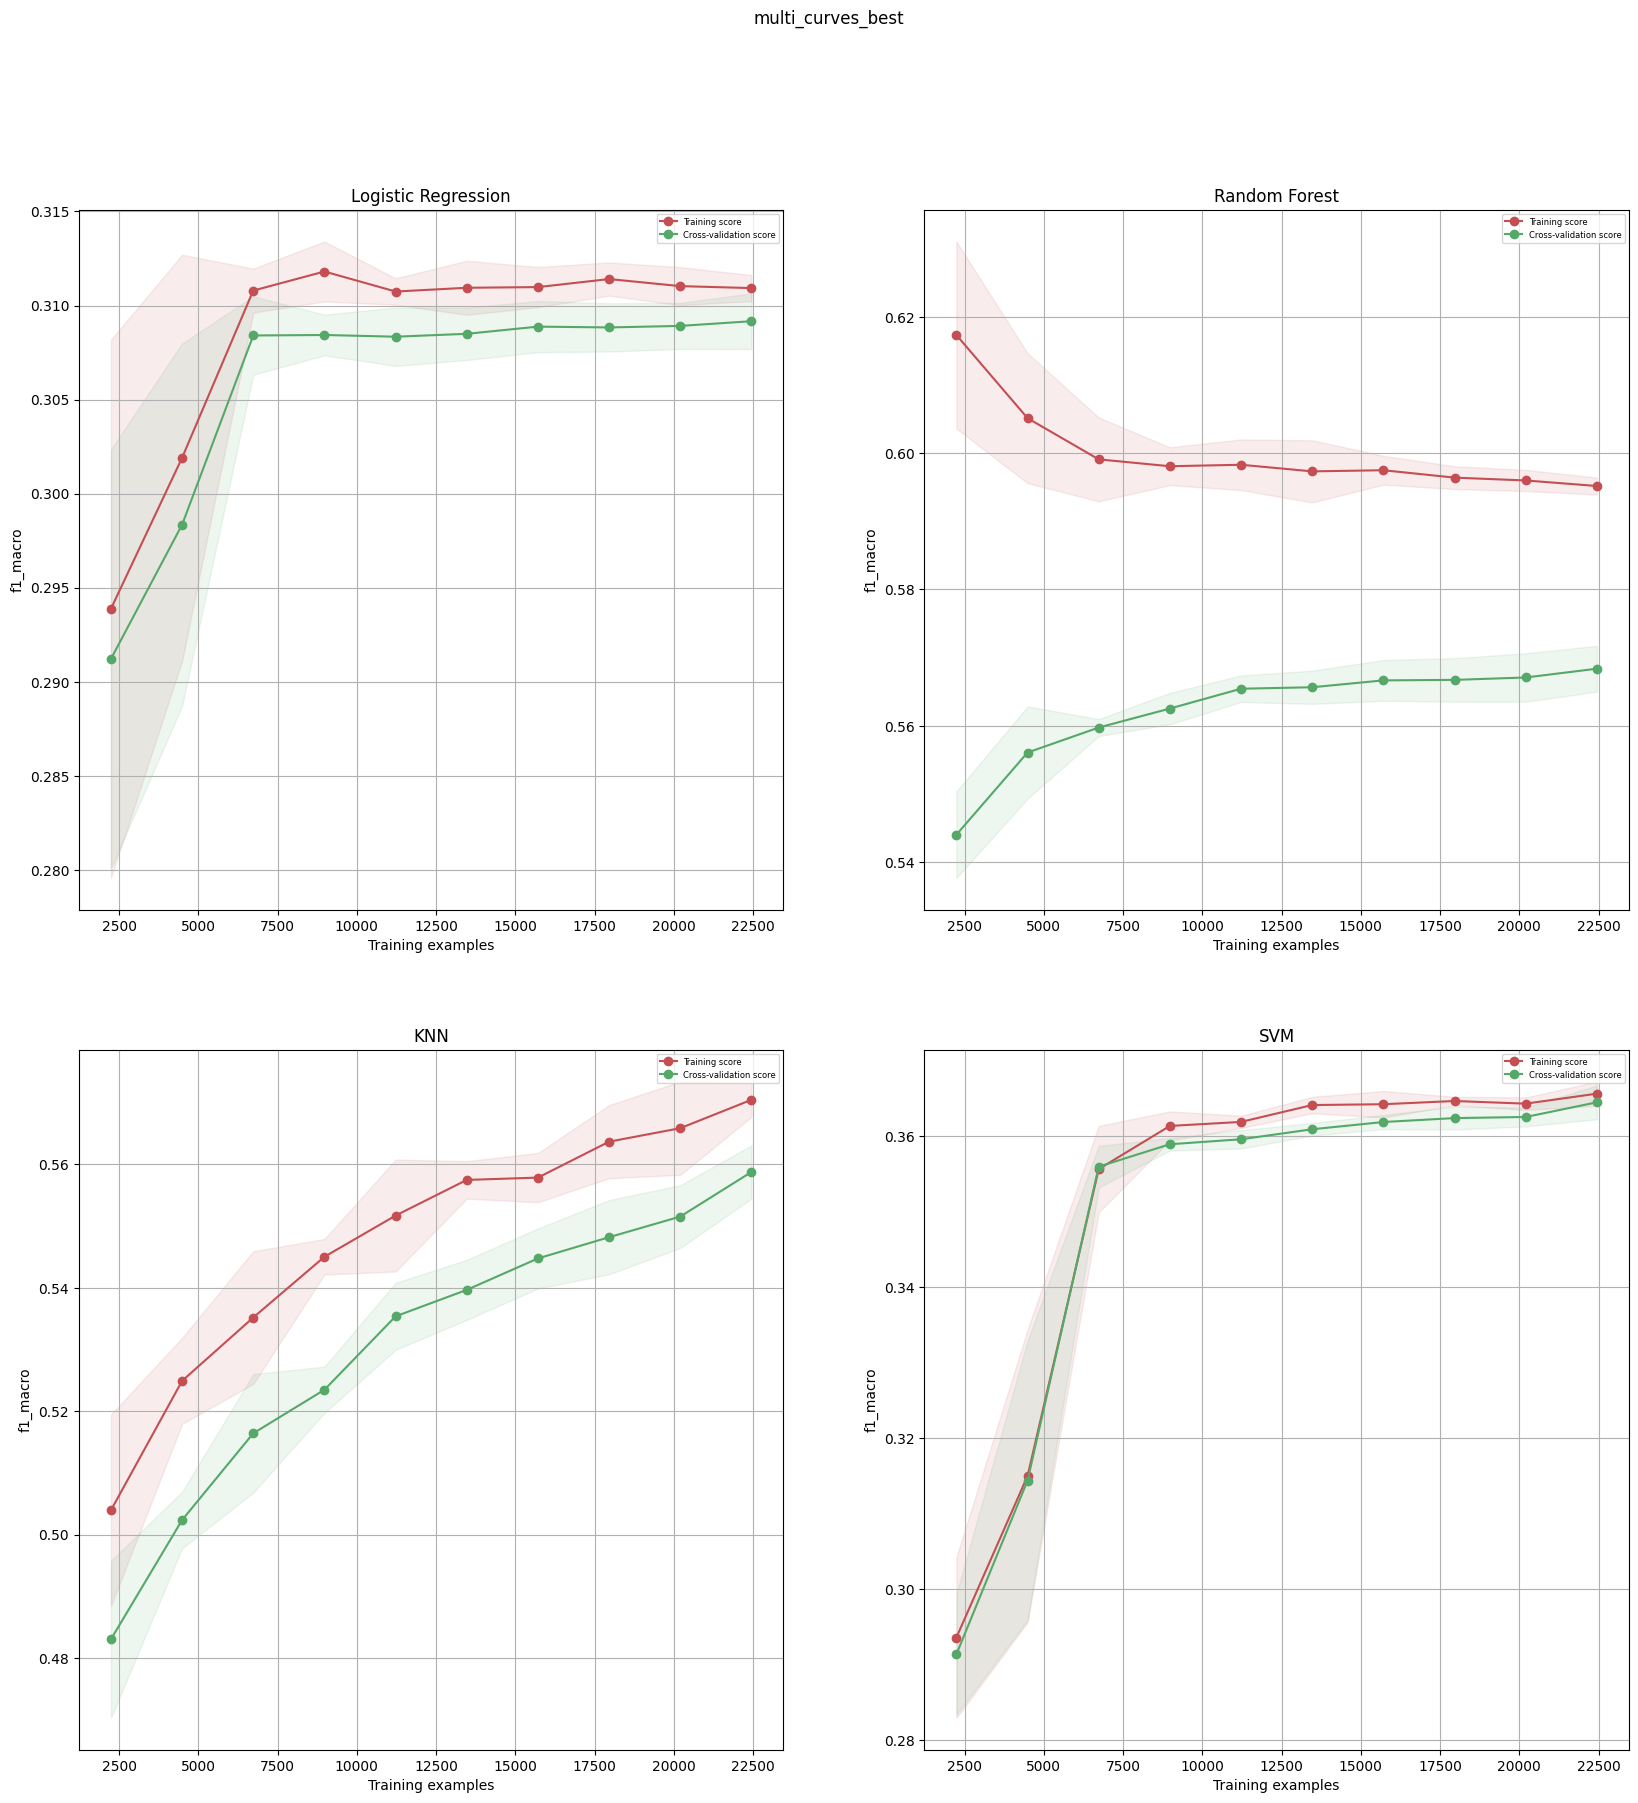

In [69]:
# y = df.Type
# X = df.drop(['Type', 'Sensor'] , axis=1)
mpl.rcParams.update(mpl.rcParamsDefault)

SPLITS = 5
TEST_SIZE = 0.40
TRAIN_SIZE = np.linspace(.1, 1.0, 10)

fig, axes = plt.subplots(round(len(models)/2), 2, figsize=(20,20))

for mod, ax in zip(models, axes.flat):
    title = mod[0]
    print("{} learning curves started".format(title))
    cv = ShuffleSplit(n_splits=SPLITS, test_size=TEST_SIZE, random_state=123123)
    print("Split done")
    plot_learning_curve(mod[1], title, best_X, y, cv=cv, train_sizes=TRAIN_SIZE, axes=ax, score="f1_macro", img_name="multi_curves_best")
    print("DONE!")
    print("-"*20)
    print()


plt.show()